In [2]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from tqdm import  tqdm

import os, json, gc, io, joblib
from contextlib import redirect_stdout

from sklearn.model_selection import train_test_split

### import Data 20

In [3]:
# Raw data
matrix_array_20 = np.load('Data/matrix_array_20_normalized.npy')
answer_array_20 = np.load('Data/answer_array_20.npy')

In [4]:
matrix_array_20.shape, answer_array_20.shape, type(matrix_array_20[0][0][0])

((580843, 20, 19), (580843, 3), numpy.float64)

In [5]:
labels = torch.tensor(answer_array_20)
indices = torch.argmax(labels, dim=1)
mapped_labels = torch.tensor([1 if i == 0 else 2 if i == 1 else 0 for i in indices])
mapped_labels

# answer = chunk.iloc[i+19][['plus_6', 'minus_6', 'zero_6']].tolist()
# 1 = up , 2 = down, 0 = zero

tensor([1, 1, 1,  ..., 1, 1, 1])

In [6]:
X = matrix_array_20
y = mapped_labels

X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.2, random_state=1, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

In [7]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(464674, 20, 19) (58084, 20, 19) (58085, 20, 19)
torch.Size([464674]) torch.Size([58084]) torch.Size([58085])


In [8]:
X_train.shape[1:], X_train[0].shape

((20, 19), (20, 19))

In [9]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use torch.long for labels if using CrossEntropyLoss
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 128  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Now your DataLoaders are ready to be used in the training loop

/tmp/ipykernel_61658/4118101478.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use torch.long for labels if using CrossEntropyLoss
/tmp/ipykernel_61658/4118101478.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
/tmp/ipykernel_61658/4118101478.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [10]:
X_train_tensor.shape

torch.Size([464674, 20, 19])

### LSTM1

In [11]:
# Custom LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()

        # Multi-layer LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=3, batch_first=True, dropout=0.2)

        # Flatten layer 

        # Define Linear layers with Batch Normalization, GELU, and Dropout
        self.linear1 = nn.Linear(hidden_dim, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.gelu1 = nn.GELU()
        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, 32)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.gelu2 = nn.GELU()
        self.dropout2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(32, 16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.gelu3 = nn.GELU()

        # Output layer
        self.output_layer = nn.Linear(16, output_dim)

    def forward(self, x):
        # Pass input through LSTM layers
        # print("Output type1:", type(x))
        (lstm_out, _) = self.lstm(x)

        # Taking the output of the last time step
        # print("Output type2:", type(x))
        x = lstm_out[:, -1, :]

        # Pass through Linear layers
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.gelu1(x)
        x = self.dropout1(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.gelu2(x)
        x = self.dropout2(x)

        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.gelu3(x)

        # Output layer
        x = self.output_layer(x)
        
        return x 


In [12]:
# Initialize the model
model = LSTMModel(input_dim=19, hidden_dim=128, output_dim=3)

In [13]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: cuda


LSTMModel(
  (lstm): LSTM(19, 128, num_layers=3, batch_first=True, dropout=0.2)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu1): GELU(approximate='none')
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu2): GELU(approximate='none')
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (batch_norm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu3): GELU(approximate='none')
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)

In [14]:
# Loss Function
criterion = nn.CrossEntropyLoss()

In [15]:
decay_params = []  # Parameters for which to apply weight decay
no_decay_params = []  # Parameters for which not to apply weight decay

for name, param in model.named_parameters():
    if not param.requires_grad:
        continue  # Skip parameters that don't require gradients
    if len(param.shape) == 1 or name.endswith(".bias") or "norm" in name:
        no_decay_params.append(param)  # No decay for biases and BN parameters
    else:
        decay_params.append(param)

In [16]:
# Now, set the optimizer with two parameter groups
optimizer = optim.Adam([
    {'params': no_decay_params, 'weight_decay': 0.0},  # No weight decay
    {'params': decay_params, 'weight_decay': 0.00}  # Apply weight decay
], lr=0.02)

In [17]:
optimizer = optim.Adam(model.parameters())

In [18]:
num_epochs = 10000000

# Early Stopping and Model Checkpoint can be manually implemented in the training loop
best_val_loss = float('inf')
patience = 10  # For early stopping

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)



In [19]:
# initialize history
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}


print('start fitting')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # for history
        # Calculate predictions for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
         # Update progress bar
        current_loss = running_loss / (i + 1)
        current_accuracy = 100 * correct / total
        pbar_train.set_postfix({'loss' : current_loss, 'accuracy': current_accuracy})
        
    # Calculate average loss and accuracy over the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_eval = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    with torch.no_grad():
        for i, (inputs, labels) in pbar_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # for history
            # Calculate predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_val_loss = val_loss / (i + 1)
            current_val_accuracy = 100 * val_correct / val_total
            pbar_eval.set_postfix({'val_loss': current_val_loss, 'val_accuracy': current_val_accuracy})
            
    # Calculate average loss and accuracy over the validation set
    val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Append to history after each epoch
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    
    # for record in command prompt
    logs = f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n'
        
    print(logs)
    with open('logs.txt','a') as f:
        f.write(logs)

    
    
    # Early stopping and Model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Models/best_model_state_dict.pth')
        torch.save(model, 'Models/best_model.pth')
        patience = 5  # Reset patience since we found a better model
    else:
        patience -= 1
        if patience == 0:
            break
    
    # Garbage collection
    gc.collect()

    
print("Training complete")


with open('Models/LSTM_history.json', 'w') as f:
    json.dump(history, f)
print('Saved history.json')

# Save final model
torch.save(model.state_dict(), 'Models/LSTM_model_state_dict.pth')
torch.save(model, 'Models/LSTM_model.pth')
print('Saved LSTM model')


start fitting


Epoch 1/10000000: 100%|██████████| 454/454 [00:00<00:00, 1109.16it/s, val_loss=0.897, val_accuracy=57]  


Epoch [1/10000000], Loss: 1.0389, Accuracy: 56.0645, Val Loss: 0.8969, Val Accuracy: 56.9572



Epoch 2/10000000: 100%|██████████| 454/454 [00:00<00:00, 1050.03it/s, val_loss=0.893, val_accuracy=57.2]


Epoch [2/10000000], Loss: 1.0051, Accuracy: 56.8878, Val Loss: 0.8935, Val Accuracy: 57.1844



Epoch 3/10000000: 100%|██████████| 454/454 [00:00<00:00, 1103.08it/s, val_loss=0.886, val_accuracy=57.4]


Epoch [3/10000000], Loss: 0.9977, Accuracy: 57.0746, Val Loss: 0.8861, Val Accuracy: 57.3893



Epoch 4/10000000: 100%|██████████| 454/454 [00:00<00:00, 1090.08it/s, val_loss=0.884, val_accuracy=57.2]


Epoch [4/10000000], Loss: 1.0150, Accuracy: 57.3030, Val Loss: 0.8843, Val Accuracy: 57.1758



Epoch 5/10000000: 100%|██████████| 454/454 [00:00<00:00, 1102.18it/s, val_loss=0.881, val_accuracy=57.7]


Epoch [5/10000000], Loss: 1.0260, Accuracy: 57.4958, Val Loss: 0.8807, Val Accuracy: 57.6923



Epoch 6/10000000: 100%|██████████| 454/454 [00:00<00:00, 1036.90it/s, val_loss=0.873, val_accuracy=58.2]


Epoch [6/10000000], Loss: 1.0122, Accuracy: 57.6804, Val Loss: 0.8734, Val Accuracy: 58.1572



Epoch 7/10000000: 100%|██████████| 454/454 [00:00<00:00, 1111.43it/s, val_loss=0.867, val_accuracy=58.1]


Epoch [7/10000000], Loss: 0.9770, Accuracy: 58.0463, Val Loss: 0.8671, Val Accuracy: 58.1399



Epoch 8/10000000: 100%|██████████| 454/454 [00:00<00:00, 1094.14it/s, val_loss=0.86, val_accuracy=58.6] 


Epoch [8/10000000], Loss: 0.9831, Accuracy: 58.3971, Val Loss: 0.8602, Val Accuracy: 58.5514



Epoch 9/10000000: 100%|██████████| 454/454 [00:00<00:00, 1046.20it/s, val_loss=0.852, val_accuracy=58.9]


Epoch [9/10000000], Loss: 0.9678, Accuracy: 58.8010, Val Loss: 0.8522, Val Accuracy: 58.8510



Epoch 10/10000000: 100%|██████████| 454/454 [00:00<00:00, 1104.61it/s, val_loss=0.84, val_accuracy=59.5] 


Epoch [10/10000000], Loss: 0.9613, Accuracy: 59.2219, Val Loss: 0.8402, Val Accuracy: 59.4725



Epoch 11/10000000: 100%|██████████| 454/454 [00:00<00:00, 1107.62it/s, val_loss=0.835, val_accuracy=59.6]


Epoch [11/10000000], Loss: 0.9873, Accuracy: 59.6016, Val Loss: 0.8347, Val Accuracy: 59.5878



Epoch 12/10000000: 100%|██████████| 454/454 [00:00<00:00, 1057.70it/s, val_loss=0.834, val_accuracy=59.8]


Epoch [12/10000000], Loss: 0.9704, Accuracy: 60.1064, Val Loss: 0.8345, Val Accuracy: 59.8289



Epoch 13/10000000: 100%|██████████| 454/454 [00:00<00:00, 1077.68it/s, val_loss=0.816, val_accuracy=60.3]


Epoch [13/10000000], Loss: 0.9490, Accuracy: 60.7082, Val Loss: 0.8157, Val Accuracy: 60.3075



Epoch 14/10000000: 100%|██████████| 454/454 [00:00<00:00, 1107.55it/s, val_loss=0.808, val_accuracy=60.9]


Epoch [14/10000000], Loss: 0.9741, Accuracy: 61.3247, Val Loss: 0.8080, Val Accuracy: 60.8653



Epoch 15/10000000: 100%|██████████| 454/454 [00:00<00:00, 1052.15it/s, val_loss=0.792, val_accuracy=62.2]


Epoch [15/10000000], Loss: 0.9525, Accuracy: 62.0235, Val Loss: 0.7924, Val Accuracy: 62.2151



Epoch 16/10000000: 100%|██████████| 454/454 [00:00<00:00, 1103.74it/s, val_loss=0.78, val_accuracy=63.3] 


Epoch [16/10000000], Loss: 0.9209, Accuracy: 63.1131, Val Loss: 0.7801, Val Accuracy: 63.3307



Epoch 17/10000000: 100%|██████████| 454/454 [00:00<00:00, 1104.79it/s, val_loss=0.766, val_accuracy=64.6]


Epoch [17/10000000], Loss: 0.9244, Accuracy: 64.1424, Val Loss: 0.7658, Val Accuracy: 64.5858



Epoch 18/10000000: 100%|██████████| 454/454 [00:00<00:00, 1097.79it/s, val_loss=0.751, val_accuracy=65.7]


Epoch [18/10000000], Loss: 0.8968, Accuracy: 65.3105, Val Loss: 0.7508, Val Accuracy: 65.6997



Epoch 19/10000000: 100%|██████████| 454/454 [00:00<00:00, 1056.92it/s, val_loss=0.74, val_accuracy=66.5] 


Epoch [19/10000000], Loss: 0.9107, Accuracy: 66.4561, Val Loss: 0.7397, Val Accuracy: 66.4865



Epoch 20/10000000: 100%|██████████| 454/454 [00:00<00:00, 1107.84it/s, val_loss=0.716, val_accuracy=68]  


Epoch [20/10000000], Loss: 0.8677, Accuracy: 67.5667, Val Loss: 0.7159, Val Accuracy: 67.9705



Epoch 21/10000000: 100%|██████████| 454/454 [00:00<00:00, 990.81it/s, val_loss=0.698, val_accuracy=68.9] 


Epoch [21/10000000], Loss: 0.8449, Accuracy: 68.6135, Val Loss: 0.6981, Val Accuracy: 68.8658



Epoch 22/10000000: 100%|██████████| 454/454 [00:00<00:00, 1095.91it/s, val_loss=0.689, val_accuracy=69.5]


Epoch [22/10000000], Loss: 0.8760, Accuracy: 69.6099, Val Loss: 0.6892, Val Accuracy: 69.5493



Epoch 23/10000000: 100%|██████████| 454/454 [00:00<00:00, 1105.81it/s, val_loss=0.666, val_accuracy=71]  


Epoch [23/10000000], Loss: 0.7990, Accuracy: 70.4668, Val Loss: 0.6663, Val Accuracy: 70.9748



Epoch 24/10000000: 100%|██████████| 454/454 [00:00<00:00, 1090.41it/s, val_loss=0.66, val_accuracy=71.6] 


Epoch [24/10000000], Loss: 0.7993, Accuracy: 71.3289, Val Loss: 0.6601, Val Accuracy: 71.5533



Epoch 25/10000000: 100%|██████████| 454/454 [00:00<00:00, 1089.93it/s, val_loss=0.64, val_accuracy=72.5] 


Epoch [25/10000000], Loss: 0.8009, Accuracy: 72.0172, Val Loss: 0.6403, Val Accuracy: 72.5432



Epoch 26/10000000: 100%|██████████| 454/454 [00:00<00:00, 1086.98it/s, val_loss=0.631, val_accuracy=73]  


Epoch [26/10000000], Loss: 0.7936, Accuracy: 72.6391, Val Loss: 0.6314, Val Accuracy: 73.0425



Epoch 27/10000000: 100%|██████████| 454/454 [00:00<00:00, 1087.10it/s, val_loss=0.622, val_accuracy=73.7]


Epoch [27/10000000], Loss: 0.7751, Accuracy: 73.3308, Val Loss: 0.6216, Val Accuracy: 73.7036



Epoch 28/10000000: 100%|██████████| 454/454 [00:00<00:00, 1111.49it/s, val_loss=0.619, val_accuracy=73.9]


Epoch [28/10000000], Loss: 0.7259, Accuracy: 73.9435, Val Loss: 0.6190, Val Accuracy: 73.8827



Epoch 29/10000000: 100%|██████████| 454/454 [00:00<00:00, 1086.98it/s, val_loss=0.6, val_accuracy=75]    


Epoch [29/10000000], Loss: 0.7611, Accuracy: 74.5140, Val Loss: 0.6004, Val Accuracy: 74.9535



Epoch 30/10000000: 100%|██████████| 454/454 [00:00<00:00, 1081.56it/s, val_loss=0.587, val_accuracy=75.4]


Epoch [30/10000000], Loss: 0.6997, Accuracy: 75.0840, Val Loss: 0.5866, Val Accuracy: 75.4046



Epoch 31/10000000: 100%|██████████| 454/454 [00:00<00:00, 1030.89it/s, val_loss=0.578, val_accuracy=76.2]


Epoch [31/10000000], Loss: 0.7355, Accuracy: 75.4163, Val Loss: 0.5782, Val Accuracy: 76.1879



Epoch 32/10000000: 100%|██████████| 454/454 [00:00<00:00, 1077.30it/s, val_loss=0.571, val_accuracy=76.3]


Epoch [32/10000000], Loss: 0.6412, Accuracy: 75.9466, Val Loss: 0.5710, Val Accuracy: 76.3412



Epoch 33/10000000: 100%|██████████| 454/454 [00:00<00:00, 1080.18it/s, val_loss=0.563, val_accuracy=76.9]


Epoch [33/10000000], Loss: 0.7108, Accuracy: 76.2995, Val Loss: 0.5626, Val Accuracy: 76.9489



Epoch 34/10000000: 100%|██████████| 454/454 [00:00<00:00, 1050.16it/s, val_loss=0.556, val_accuracy=77.3]


Epoch [34/10000000], Loss: 0.6721, Accuracy: 76.7674, Val Loss: 0.5560, Val Accuracy: 77.3259



Epoch 35/10000000: 100%|██████████| 454/454 [00:00<00:00, 1012.85it/s, val_loss=0.551, val_accuracy=77.4]


Epoch [35/10000000], Loss: 0.6364, Accuracy: 77.1414, Val Loss: 0.5512, Val Accuracy: 77.4051



Epoch 36/10000000: 100%|██████████| 454/454 [00:00<00:00, 1100.99it/s, val_loss=0.546, val_accuracy=77.9]


Epoch [36/10000000], Loss: 0.7099, Accuracy: 77.4767, Val Loss: 0.5460, Val Accuracy: 77.9165



Epoch 37/10000000: 100%|██████████| 454/454 [00:00<00:00, 1104.90it/s, val_loss=0.535, val_accuracy=78.5]


Epoch [37/10000000], Loss: 0.6346, Accuracy: 77.8059, Val Loss: 0.5348, Val Accuracy: 78.4622



Epoch 38/10000000: 100%|██████████| 454/454 [00:00<00:00, 1035.79it/s, val_loss=0.527, val_accuracy=78.9]


Epoch [38/10000000], Loss: 0.6759, Accuracy: 78.1750, Val Loss: 0.5267, Val Accuracy: 78.8668



Epoch 39/10000000: 100%|██████████| 454/454 [00:00<00:00, 1104.26it/s, val_loss=0.532, val_accuracy=78.5]


Epoch [39/10000000], Loss: 0.6422, Accuracy: 78.3653, Val Loss: 0.5317, Val Accuracy: 78.5431



Epoch 40/10000000: 100%|██████████| 454/454 [00:00<00:00, 1038.56it/s, val_loss=0.519, val_accuracy=79.1]


Epoch [40/10000000], Loss: 0.6176, Accuracy: 78.6698, Val Loss: 0.5189, Val Accuracy: 79.1406



Epoch 41/10000000: 100%|██████████| 454/454 [00:00<00:00, 1103.57it/s, val_loss=0.511, val_accuracy=79.4]


Epoch [41/10000000], Loss: 0.6265, Accuracy: 78.9726, Val Loss: 0.5105, Val Accuracy: 79.3764



Epoch 42/10000000: 100%|██████████| 454/454 [00:00<00:00, 1026.30it/s, val_loss=0.505, val_accuracy=80]  


Epoch [42/10000000], Loss: 0.7151, Accuracy: 79.2123, Val Loss: 0.5047, Val Accuracy: 79.9532



Epoch 43/10000000: 100%|██████████| 454/454 [00:00<00:00, 1045.21it/s, val_loss=0.501, val_accuracy=80.3]


Epoch [43/10000000], Loss: 0.6397, Accuracy: 79.5371, Val Loss: 0.5006, Val Accuracy: 80.3371



Epoch 44/10000000: 100%|██████████| 454/454 [00:00<00:00, 1104.36it/s, val_loss=0.5, val_accuracy=80.2]  


Epoch [44/10000000], Loss: 0.6369, Accuracy: 79.6926, Val Loss: 0.5000, Val Accuracy: 80.1563



Epoch 45/10000000: 100%|██████████| 454/454 [00:00<00:00, 1000.45it/s, val_loss=0.492, val_accuracy=80.4]


Epoch [45/10000000], Loss: 0.5363, Accuracy: 80.0566, Val Loss: 0.4924, Val Accuracy: 80.4163



Epoch 46/10000000: 100%|██████████| 454/454 [00:00<00:00, 1100.97it/s, val_loss=0.488, val_accuracy=80.8]


Epoch [46/10000000], Loss: 0.5785, Accuracy: 80.1562, Val Loss: 0.4876, Val Accuracy: 80.7503



Epoch 47/10000000: 100%|██████████| 454/454 [00:00<00:00, 1065.20it/s, val_loss=0.487, val_accuracy=80.8]


Epoch [47/10000000], Loss: 0.6220, Accuracy: 80.3303, Val Loss: 0.4874, Val Accuracy: 80.7882



Epoch 48/10000000: 100%|██████████| 454/454 [00:00<00:00, 1097.53it/s, val_loss=0.483, val_accuracy=81]  


Epoch [48/10000000], Loss: 0.6677, Accuracy: 80.5823, Val Loss: 0.4825, Val Accuracy: 81.0034



Epoch 49/10000000: 100%|██████████| 454/454 [00:00<00:00, 1084.84it/s, val_loss=0.478, val_accuracy=81.2]


Epoch [49/10000000], Loss: 0.5895, Accuracy: 80.8461, Val Loss: 0.4784, Val Accuracy: 81.2461



Epoch 50/10000000: 100%|██████████| 454/454 [00:00<00:00, 1045.64it/s, val_loss=0.476, val_accuracy=81.5]


Epoch [50/10000000], Loss: 0.6125, Accuracy: 80.9307, Val Loss: 0.4755, Val Accuracy: 81.4768



Epoch 51/10000000: 100%|██████████| 454/454 [00:00<00:00, 1079.76it/s, val_loss=0.472, val_accuracy=81.6]


Epoch [51/10000000], Loss: 0.5825, Accuracy: 81.1989, Val Loss: 0.4716, Val Accuracy: 81.5767



Epoch 52/10000000: 100%|██████████| 454/454 [00:00<00:00, 1075.10it/s, val_loss=0.469, val_accuracy=81.6]


Epoch [52/10000000], Loss: 0.5504, Accuracy: 81.3885, Val Loss: 0.4692, Val Accuracy: 81.6455



Epoch 53/10000000: 100%|██████████| 454/454 [00:00<00:00, 1095.62it/s, val_loss=0.472, val_accuracy=81.6]


Epoch [53/10000000], Loss: 0.5767, Accuracy: 81.4986, Val Loss: 0.4717, Val Accuracy: 81.5698



Epoch 54/10000000: 100%|██████████| 454/454 [00:00<00:00, 1090.31it/s, val_loss=0.462, val_accuracy=82.1]


Epoch [54/10000000], Loss: 0.5246, Accuracy: 81.7044, Val Loss: 0.4616, Val Accuracy: 82.1242



Epoch 55/10000000: 100%|██████████| 454/454 [00:00<00:00, 1100.74it/s, val_loss=0.454, val_accuracy=82.5]


Epoch [55/10000000], Loss: 0.5260, Accuracy: 81.9194, Val Loss: 0.4540, Val Accuracy: 82.5270



Epoch 56/10000000: 100%|██████████| 454/454 [00:00<00:00, 991.61it/s, val_loss=0.453, val_accuracy=82.5]


Epoch [56/10000000], Loss: 0.5421, Accuracy: 81.9353, Val Loss: 0.4534, Val Accuracy: 82.5270



Epoch 57/10000000: 100%|██████████| 454/454 [00:00<00:00, 1088.05it/s, val_loss=0.456, val_accuracy=82.3]


Epoch [57/10000000], Loss: 0.5619, Accuracy: 82.1854, Val Loss: 0.4563, Val Accuracy: 82.2826



Epoch 58/10000000: 100%|██████████| 454/454 [00:00<00:00, 1064.88it/s, val_loss=0.443, val_accuracy=83]  


Epoch [58/10000000], Loss: 0.5564, Accuracy: 82.3366, Val Loss: 0.4435, Val Accuracy: 82.9540



Epoch 59/10000000: 100%|██████████| 454/454 [00:00<00:00, 1050.86it/s, val_loss=0.451, val_accuracy=82.7]


Epoch [59/10000000], Loss: 0.5229, Accuracy: 82.4266, Val Loss: 0.4508, Val Accuracy: 82.7474



Epoch 60/10000000: 100%|██████████| 454/454 [00:00<00:00, 1056.78it/s, val_loss=0.444, val_accuracy=82.8]


Epoch [60/10000000], Loss: 0.5015, Accuracy: 82.5650, Val Loss: 0.4443, Val Accuracy: 82.7595



Epoch 61/10000000: 100%|██████████| 454/454 [00:00<00:00, 1088.51it/s, val_loss=0.446, val_accuracy=82.8]


Epoch [61/10000000], Loss: 0.5612, Accuracy: 82.6799, Val Loss: 0.4456, Val Accuracy: 82.8145



Epoch 62/10000000: 100%|██████████| 454/454 [00:00<00:00, 960.84it/s, val_loss=0.436, val_accuracy=83.3]


Epoch [62/10000000], Loss: 0.5007, Accuracy: 82.7935, Val Loss: 0.4359, Val Accuracy: 83.3242



Epoch 63/10000000: 100%|██████████| 454/454 [00:00<00:00, 1075.57it/s, val_loss=0.431, val_accuracy=83.7]


Epoch [63/10000000], Loss: 0.4723, Accuracy: 82.9734, Val Loss: 0.4307, Val Accuracy: 83.6599



Epoch 64/10000000: 100%|██████████| 454/454 [00:00<00:00, 1108.80it/s, val_loss=0.44, val_accuracy=83]   


Epoch [64/10000000], Loss: 0.5248, Accuracy: 83.1193, Val Loss: 0.4398, Val Accuracy: 83.0435



Epoch 65/10000000: 100%|██████████| 454/454 [00:00<00:00, 1037.02it/s, val_loss=0.43, val_accuracy=83.5] 


Epoch [65/10000000], Loss: 0.4990, Accuracy: 83.2980, Val Loss: 0.4299, Val Accuracy: 83.5307



Epoch 66/10000000: 100%|██████████| 454/454 [00:00<00:00, 1106.98it/s, val_loss=0.427, val_accuracy=83.7]


Epoch [66/10000000], Loss: 0.4698, Accuracy: 83.3070, Val Loss: 0.4272, Val Accuracy: 83.7494



Epoch 67/10000000: 100%|██████████| 454/454 [00:00<00:00, 1092.79it/s, val_loss=0.422, val_accuracy=83.8]


Epoch [67/10000000], Loss: 0.5582, Accuracy: 83.4290, Val Loss: 0.4222, Val Accuracy: 83.8010



Epoch 68/10000000: 100%|██████████| 454/454 [00:00<00:00, 1064.85it/s, val_loss=0.418, val_accuracy=83.9]


Epoch [68/10000000], Loss: 0.5322, Accuracy: 83.5334, Val Loss: 0.4184, Val Accuracy: 83.9061



Epoch 69/10000000: 100%|██████████| 454/454 [00:00<00:00, 1104.92it/s, val_loss=0.417, val_accuracy=84.2]


Epoch [69/10000000], Loss: 0.4565, Accuracy: 83.6647, Val Loss: 0.4167, Val Accuracy: 84.2056



Epoch 70/10000000: 100%|██████████| 454/454 [00:00<00:00, 1106.86it/s, val_loss=0.423, val_accuracy=84]  


Epoch [70/10000000], Loss: 0.4751, Accuracy: 83.7944, Val Loss: 0.4226, Val Accuracy: 83.9508



Epoch 71/10000000: 100%|██████████| 454/454 [00:00<00:00, 1079.38it/s, val_loss=0.418, val_accuracy=84]  


Epoch [71/10000000], Loss: 0.5002, Accuracy: 83.9109, Val Loss: 0.4177, Val Accuracy: 84.0455



Epoch 72/10000000: 100%|██████████| 454/454 [00:00<00:00, 1077.39it/s, val_loss=0.41, val_accuracy=84.3] 


Epoch [72/10000000], Loss: 0.4704, Accuracy: 83.9565, Val Loss: 0.4098, Val Accuracy: 84.3193



Epoch 73/10000000: 100%|██████████| 454/454 [00:00<00:00, 1105.52it/s, val_loss=0.417, val_accuracy=84.1]


Epoch [73/10000000], Loss: 0.4631, Accuracy: 84.0854, Val Loss: 0.4172, Val Accuracy: 84.1437



Epoch 74/10000000: 100%|██████████| 454/454 [00:00<00:00, 995.00it/s, val_loss=0.411, val_accuracy=84.4] 


Epoch [74/10000000], Loss: 0.4872, Accuracy: 84.1454, Val Loss: 0.4113, Val Accuracy: 84.3709



Epoch 75/10000000: 100%|██████████| 454/454 [00:00<00:00, 1088.43it/s, val_loss=0.405, val_accuracy=84.6]


Epoch [75/10000000], Loss: 0.4673, Accuracy: 84.2744, Val Loss: 0.4052, Val Accuracy: 84.6464



Epoch 76/10000000: 100%|██████████| 454/454 [00:00<00:00, 1077.71it/s, val_loss=0.403, val_accuracy=84.8]


Epoch [76/10000000], Loss: 0.4519, Accuracy: 84.3533, Val Loss: 0.4029, Val Accuracy: 84.7566



Epoch 77/10000000: 100%|██████████| 454/454 [00:00<00:00, 1050.97it/s, val_loss=0.406, val_accuracy=84.5]


Epoch [77/10000000], Loss: 0.4093, Accuracy: 84.4211, Val Loss: 0.4064, Val Accuracy: 84.5465



Epoch 78/10000000: 100%|██████████| 454/454 [00:00<00:00, 1064.27it/s, val_loss=0.404, val_accuracy=84.7]


Epoch [78/10000000], Loss: 0.4286, Accuracy: 84.4648, Val Loss: 0.4042, Val Accuracy: 84.6929



Epoch 79/10000000: 100%|██████████| 454/454 [00:00<00:00, 1101.63it/s, val_loss=0.402, val_accuracy=84.9]


Epoch [79/10000000], Loss: 0.4298, Accuracy: 84.6852, Val Loss: 0.4025, Val Accuracy: 84.9373



Epoch 80/10000000: 100%|██████████| 454/454 [00:00<00:00, 1056.52it/s, val_loss=0.41, val_accuracy=84.6] 


Epoch [80/10000000], Loss: 0.4642, Accuracy: 84.6923, Val Loss: 0.4098, Val Accuracy: 84.5586



Epoch 81/10000000: 100%|██████████| 454/454 [00:00<00:00, 1066.21it/s, val_loss=0.394, val_accuracy=85.3]


Epoch [81/10000000], Loss: 0.3886, Accuracy: 84.7678, Val Loss: 0.3935, Val Accuracy: 85.2507



Epoch 82/10000000: 100%|██████████| 454/454 [00:00<00:00, 1103.70it/s, val_loss=0.397, val_accuracy=85.2]


Epoch [82/10000000], Loss: 0.4100, Accuracy: 84.9327, Val Loss: 0.3966, Val Accuracy: 85.1508



Epoch 83/10000000: 100%|██████████| 454/454 [00:00<00:00, 1019.08it/s, val_loss=0.396, val_accuracy=85.2]


Epoch [83/10000000], Loss: 0.5009, Accuracy: 84.9789, Val Loss: 0.3961, Val Accuracy: 85.2386



Epoch 84/10000000: 100%|██████████| 454/454 [00:00<00:00, 1105.06it/s, val_loss=0.395, val_accuracy=85.3]


Epoch [84/10000000], Loss: 0.4094, Accuracy: 85.0340, Val Loss: 0.3955, Val Accuracy: 85.2524



Epoch 85/10000000: 100%|██████████| 454/454 [00:00<00:00, 1077.33it/s, val_loss=0.392, val_accuracy=85.4]


Epoch [85/10000000], Loss: 0.4219, Accuracy: 85.0652, Val Loss: 0.3918, Val Accuracy: 85.4125



Epoch 86/10000000: 100%|██████████| 454/454 [00:00<00:00, 1111.63it/s, val_loss=0.391, val_accuracy=85.6]


Epoch [86/10000000], Loss: 0.4127, Accuracy: 85.1184, Val Loss: 0.3911, Val Accuracy: 85.5726



Epoch 87/10000000: 100%|██████████| 454/454 [00:00<00:00, 1102.98it/s, val_loss=0.382, val_accuracy=85.9]


Epoch [87/10000000], Loss: 0.3877, Accuracy: 85.2021, Val Loss: 0.3825, Val Accuracy: 85.8636



Epoch 88/10000000: 100%|██████████| 454/454 [00:00<00:00, 1106.02it/s, val_loss=0.389, val_accuracy=85.5]


Epoch [88/10000000], Loss: 0.4643, Accuracy: 85.3547, Val Loss: 0.3888, Val Accuracy: 85.5434



Epoch 89/10000000: 100%|██████████| 454/454 [00:00<00:00, 1018.36it/s, val_loss=0.398, val_accuracy=85.1]


Epoch [89/10000000], Loss: 0.4087, Accuracy: 85.3394, Val Loss: 0.3983, Val Accuracy: 85.0647



Epoch 90/10000000: 100%|██████████| 454/454 [00:00<00:00, 1069.53it/s, val_loss=0.386, val_accuracy=85.6]


Epoch [90/10000000], Loss: 0.4698, Accuracy: 85.4145, Val Loss: 0.3864, Val Accuracy: 85.6432



Epoch 91/10000000: 100%|██████████| 454/454 [00:00<00:00, 1076.03it/s, val_loss=0.383, val_accuracy=85.8]


Epoch [91/10000000], Loss: 0.4449, Accuracy: 85.4937, Val Loss: 0.3832, Val Accuracy: 85.7861



Epoch 92/10000000: 100%|██████████| 454/454 [00:00<00:00, 1098.43it/s, val_loss=0.382, val_accuracy=85.9]


Epoch [92/10000000], Loss: 0.4540, Accuracy: 85.6035, Val Loss: 0.3816, Val Accuracy: 85.9118



Epoch 93/10000000: 100%|██████████| 454/454 [00:00<00:00, 1010.04it/s, val_loss=0.38, val_accuracy=86]   


Epoch [93/10000000], Loss: 0.4387, Accuracy: 85.6857, Val Loss: 0.3798, Val Accuracy: 86.0048



Epoch 94/10000000: 100%|██████████| 454/454 [00:00<00:00, 1079.50it/s, val_loss=0.379, val_accuracy=85.9]


Epoch [94/10000000], Loss: 0.3972, Accuracy: 85.6953, Val Loss: 0.3789, Val Accuracy: 85.9169



Epoch 95/10000000: 100%|██████████| 454/454 [00:00<00:00, 1019.84it/s, val_loss=0.381, val_accuracy=86] 


Epoch [95/10000000], Loss: 0.4234, Accuracy: 85.7511, Val Loss: 0.3806, Val Accuracy: 86.0461



Epoch 96/10000000: 100%|██████████| 454/454 [00:00<00:00, 1102.92it/s, val_loss=0.382, val_accuracy=85.8]


Epoch [96/10000000], Loss: 0.3683, Accuracy: 85.7877, Val Loss: 0.3818, Val Accuracy: 85.7913



Epoch 97/10000000: 100%|██████████| 454/454 [00:00<00:00, 1018.45it/s, val_loss=0.38, val_accuracy=86]  


Epoch [97/10000000], Loss: 0.3929, Accuracy: 85.8875, Val Loss: 0.3800, Val Accuracy: 86.0409



Epoch 98/10000000: 100%|██████████| 454/454 [00:00<00:00, 1085.61it/s, val_loss=0.376, val_accuracy=86.1]


Epoch [98/10000000], Loss: 0.4047, Accuracy: 85.9267, Val Loss: 0.3759, Val Accuracy: 86.1132



Epoch 99/10000000: 100%|██████████| 454/454 [00:00<00:00, 1105.18it/s, val_loss=0.374, val_accuracy=86]  


Epoch [99/10000000], Loss: 0.3913, Accuracy: 85.9454, Val Loss: 0.3744, Val Accuracy: 85.9755



Epoch 100/10000000: 100%|██████████| 454/454 [00:00<00:00, 1087.70it/s, val_loss=0.377, val_accuracy=85.9]


Epoch [100/10000000], Loss: 0.4047, Accuracy: 86.1311, Val Loss: 0.3771, Val Accuracy: 85.8860



Epoch 101/10000000: 100%|██████████| 454/454 [00:00<00:00, 1030.22it/s, val_loss=0.373, val_accuracy=86.2]


Epoch [101/10000000], Loss: 0.3596, Accuracy: 86.1077, Val Loss: 0.3725, Val Accuracy: 86.2131



Epoch 102/10000000: 100%|██████████| 454/454 [00:00<00:00, 1096.06it/s, val_loss=0.372, val_accuracy=86.2]


Epoch [102/10000000], Loss: 0.3845, Accuracy: 86.1346, Val Loss: 0.3719, Val Accuracy: 86.2423



Epoch 103/10000000: 100%|██████████| 454/454 [00:00<00:00, 1103.53it/s, val_loss=0.367, val_accuracy=86.5]


Epoch [103/10000000], Loss: 0.4106, Accuracy: 86.2486, Val Loss: 0.3675, Val Accuracy: 86.4851



Epoch 104/10000000: 100%|██████████| 454/454 [00:00<00:00, 1107.36it/s, val_loss=0.376, val_accuracy=86.1]


Epoch [104/10000000], Loss: 0.4109, Accuracy: 86.3237, Val Loss: 0.3756, Val Accuracy: 86.0908



Epoch 105/10000000: 100%|██████████| 454/454 [00:00<00:00, 1104.41it/s, val_loss=0.371, val_accuracy=86.3]


Epoch [105/10000000], Loss: 0.4290, Accuracy: 86.3117, Val Loss: 0.3709, Val Accuracy: 86.3336



Epoch 106/10000000: 100%|██████████| 454/454 [00:00<00:00, 1108.00it/s, val_loss=0.369, val_accuracy=86.4]


Epoch [106/10000000], Loss: 0.4035, Accuracy: 86.3978, Val Loss: 0.3691, Val Accuracy: 86.4042



Epoch 107/10000000: 100%|██████████| 454/454 [00:00<00:00, 1042.39it/s, val_loss=0.369, val_accuracy=86.4]


Epoch [107/10000000], Loss: 0.4362, Accuracy: 86.4008, Val Loss: 0.3694, Val Accuracy: 86.4266



Epoch 108/10000000: 100%|██████████| 454/454 [00:00<00:00, 1058.78it/s, val_loss=0.365, val_accuracy=86.6]


Epoch [108/10000000], Loss: 0.3811, Accuracy: 86.4288, Val Loss: 0.3654, Val Accuracy: 86.6108



Epoch 109/10000000: 100%|██████████| 454/454 [00:00<00:00, 1000.04it/s, val_loss=0.375, val_accuracy=86.1]


Epoch [109/10000000], Loss: 0.3572, Accuracy: 86.5499, Val Loss: 0.3754, Val Accuracy: 86.1149



Epoch 110/10000000: 100%|██████████| 454/454 [00:00<00:00, 1102.34it/s, val_loss=0.364, val_accuracy=86.6]


Epoch [110/10000000], Loss: 0.3639, Accuracy: 86.6123, Val Loss: 0.3639, Val Accuracy: 86.6280



Epoch 111/10000000: 100%|██████████| 454/454 [00:00<00:00, 1081.44it/s, val_loss=0.364, val_accuracy=86.7]


Epoch [111/10000000], Loss: 0.3774, Accuracy: 86.6095, Val Loss: 0.3644, Val Accuracy: 86.6727



Epoch 112/10000000: 100%|██████████| 454/454 [00:00<00:00, 1061.57it/s, val_loss=0.365, val_accuracy=86.6]


Epoch [112/10000000], Loss: 0.3781, Accuracy: 86.7604, Val Loss: 0.3648, Val Accuracy: 86.5918



Epoch 113/10000000: 100%|██████████| 454/454 [00:00<00:00, 1101.92it/s, val_loss=0.362, val_accuracy=86.8]


Epoch [113/10000000], Loss: 0.3645, Accuracy: 86.6788, Val Loss: 0.3622, Val Accuracy: 86.7571



Epoch 114/10000000: 100%|██████████| 454/454 [00:00<00:00, 1096.15it/s, val_loss=0.366, val_accuracy=86.7]


Epoch [114/10000000], Loss: 0.3591, Accuracy: 86.7720, Val Loss: 0.3657, Val Accuracy: 86.7416



Epoch 115/10000000: 100%|██████████| 454/454 [00:00<00:00, 1023.44it/s, val_loss=0.358, val_accuracy=86.9]


Epoch [115/10000000], Loss: 0.3773, Accuracy: 86.7920, Val Loss: 0.3575, Val Accuracy: 86.9086



Epoch 116/10000000: 100%|██████████| 454/454 [00:00<00:00, 1105.77it/s, val_loss=0.358, val_accuracy=86.9]


Epoch [116/10000000], Loss: 0.4188, Accuracy: 86.8917, Val Loss: 0.3582, Val Accuracy: 86.9344



Epoch 117/10000000: 100%|██████████| 454/454 [00:00<00:00, 1105.15it/s, val_loss=0.365, val_accuracy=86.6]


Epoch [117/10000000], Loss: 0.4146, Accuracy: 86.8828, Val Loss: 0.3648, Val Accuracy: 86.5626



Epoch 118/10000000: 100%|██████████| 454/454 [00:00<00:00, 1098.17it/s, val_loss=0.351, val_accuracy=87.3]


Epoch [118/10000000], Loss: 0.4426, Accuracy: 86.9745, Val Loss: 0.3513, Val Accuracy: 87.2667



Epoch 119/10000000: 100%|██████████| 454/454 [00:00<00:00, 1106.69it/s, val_loss=0.357, val_accuracy=87]  


Epoch [119/10000000], Loss: 0.3629, Accuracy: 87.0604, Val Loss: 0.3567, Val Accuracy: 86.9826



Epoch 120/10000000: 100%|██████████| 454/454 [00:00<00:00, 1107.70it/s, val_loss=0.357, val_accuracy=87.1]


Epoch [120/10000000], Loss: 0.3972, Accuracy: 87.0662, Val Loss: 0.3569, Val Accuracy: 87.0773



Epoch 121/10000000: 100%|██████████| 454/454 [00:00<00:00, 1081.80it/s, val_loss=0.354, val_accuracy=87.2]


Epoch [121/10000000], Loss: 0.3373, Accuracy: 87.0918, Val Loss: 0.3541, Val Accuracy: 87.1858



Epoch 122/10000000: 100%|██████████| 454/454 [00:00<00:00, 1101.81it/s, val_loss=0.357, val_accuracy=87.2]


Epoch [122/10000000], Loss: 0.4039, Accuracy: 87.0802, Val Loss: 0.3572, Val Accuracy: 87.1910



Epoch 123/10000000: 100%|██████████| 454/454 [00:00<00:00, 1105.10it/s, val_loss=0.358, val_accuracy=87]  


Epoch [123/10000000], Loss: 0.3528, Accuracy: 87.1736, Val Loss: 0.3580, Val Accuracy: 86.9654

Training complete
Saved history.json
Saved LSTM model


In [20]:
state_dict = torch.load('Models/LSTM_model_state_dict.pth')
model.load_state_dict(state_dict)

# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
model = model.to(device)

In [21]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    # Wrap your loader with tqdm for a progress bar
    pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch 1/1")
    for i, (images, labels) in pbar_test:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update progress bar
        # pbar_test.set_postfix({'loss': running_loss / (i + 1)})

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')



Epoch 1/1: 100%|██████████| 454/454 [00:00<00:00, 1339.43it/s]

Accuracy of the model on the test images: 86.9398295601274%


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.8685419894367593
Recall: 0.869398295601274
F1 Score: 0.8682486043601709
Confusion Matrix:
 [[27699  1096   841]
 [ 1661 11262   984]
 [ 1849  1155 11538]]


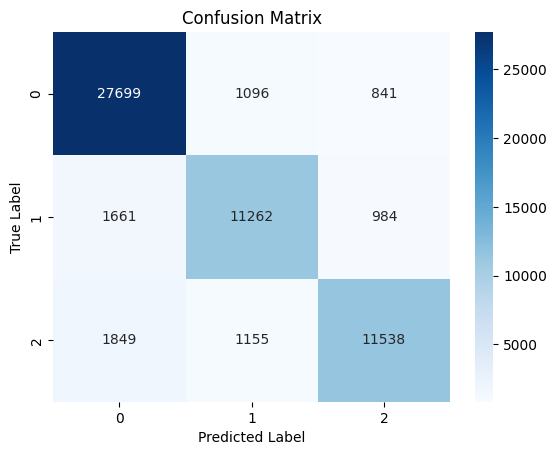

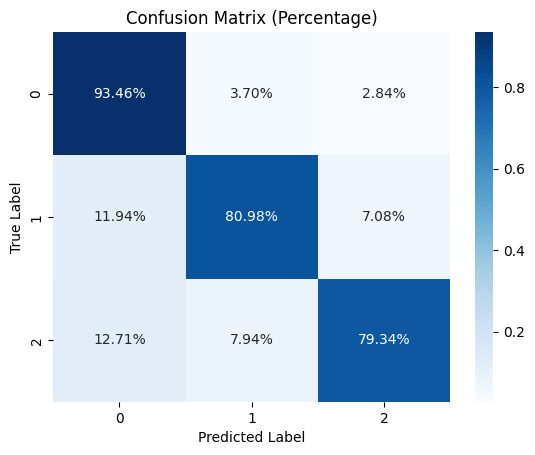

In [23]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

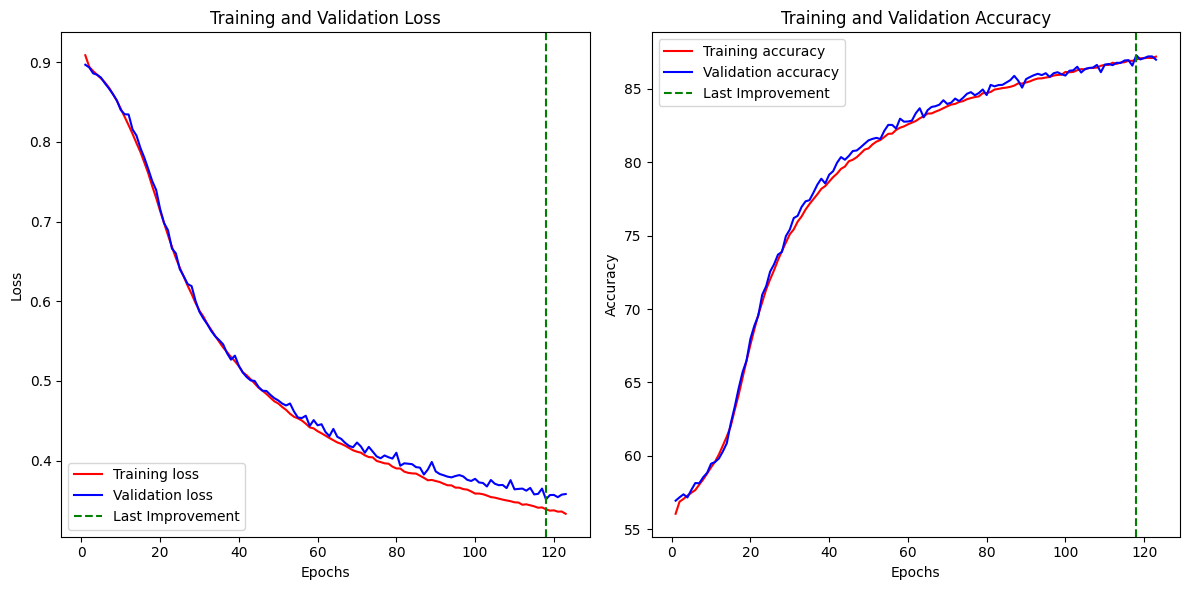

In [24]:
with open('Models/LSTM_history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs
last_improvement_epoch = len(train_loss) - 5

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement') 
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

### GRUs (Gated Recurrent Units)

In [22]:
# Custom GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # GRU Layer
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)

        # Flatten layer 

        # Define Linear layers with Batch Normalization, GELU, and Dropout
        self.linear1 = nn.Linear(hidden_dim, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.gelu1 = nn.GELU()
        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, 32)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.gelu2 = nn.GELU()
        self.dropout2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(32, 16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.gelu3 = nn.GELU()

        # Output layer
        self.output_layer = nn.Linear(16, output_dim)

    def forward(self, x):
        # Pass input through GRU layers
        # print("Output type1:", type(x))
        gru_out, _ = self.gru(x)

        # Taking the output of the last time step
        # print("Output type2:", type(x))
        x = gru_out[:, -1, :]

        # Pass through Linear layers
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.gelu1(x)
        x = self.dropout1(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.gelu2(x)
        x = self.dropout2(x)

        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.gelu3(x)

        # Output layer
        x = self.output_layer(x)
        
        return x 


In [23]:
input_dim = 19  # Number of input features
hidden_dim = 128  # Number of hidden units
output_dim = 3  # Number of output classes
num_layers = 2  # Number of GRU layers

# initialize Model
model = GRUModel(input_dim, hidden_dim, output_dim, num_layers)

In [24]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)


Using device: cpu


GRUModel(
  (gru): GRU(19, 128, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu1): GELU(approximate='none')
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu2): GELU(approximate='none')
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (batch_norm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu3): GELU(approximate='none')
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)

In [25]:
# Loss Function
criterion = nn.CrossEntropyLoss()

In [26]:
optimizer = optim.Adam(model.parameters())

In [27]:
num_epochs = 10000000

# Early Stopping and Model Checkpoint can be manually implemented in the training loop
best_val_loss = float('inf')
patience = 10  # For early stopping

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)



In [ ]:
# initialize history
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}


print('start fitting')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # for history
        # Calculate predictions for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
         # Update progress bar
        current_loss = running_loss / (i + 1)
        current_accuracy = 100 * correct / total
        pbar_train.set_postfix({'loss' : current_loss, 'accuracy': current_accuracy})
        
    # Calculate average loss and accuracy over the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_eval = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    with torch.no_grad():
        for i, (inputs, labels) in pbar_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # for history
            # Calculate predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_val_loss = val_loss / (i + 1)
            current_val_accuracy = 100 * val_correct / val_total
            pbar_eval.set_postfix({'val_loss': current_val_loss, 'val_accuracy': current_val_accuracy})
            
    # Calculate average loss and accuracy over the validation set
    val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Append to history after each epoch
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    
    # for record in command prompt
    logs = f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n'
        
    print(logs)
    with open('logs.txt','a') as f:
        f.write(logs)

    
    
    # Early stopping and Model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Models/best_model_state_dict.pth')
        torch.save(model, 'Models/best_model.pth')
        patience = 5  # Reset patience since we found a better model
    else:
        patience -= 1
        if patience == 0:
            break
    
    # Garbage collection
    gc.collect()

    
print("Training complete")


with open('Models/GRU_history.json', 'w') as f:
    json.dump(history, f)
print('Saved history.json')

# Save final model
torch.save(model.state_dict(), 'Models/GRU_model_state_dict.pth')
torch.save(model, 'Models/GRU_model.pth')
print('Saved GRU model')


In [28]:
state_dict = torch.load('Models/GRU_model_state_dict.pth')
model.load_state_dict(state_dict)

# Setting device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = model.to(device)

In [29]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    # Wrap your loader with tqdm for a progress bar
    pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch 1/1")
    for i, (images, labels) in pbar_test:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update progress bar
        # pbar_test.set_postfix({'loss': running_loss / (i + 1)})

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')



Epoch 1/1:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch 1/1: 100%|██████████| 460/460 [00:16<00:00, 28.27it/s]

Accuracy of the model on the test images: 77.02911993464609%


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.7706763988395465
Recall: 0.7702911993464608
F1 Score: 0.7702527511042238
Confusion Matrix:
 [[15001  1659  2057]
 [ 1866 14451  3378]
 [ 1746  2791 15808]]


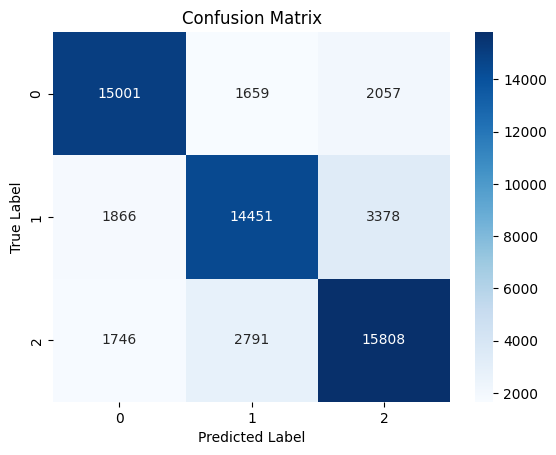

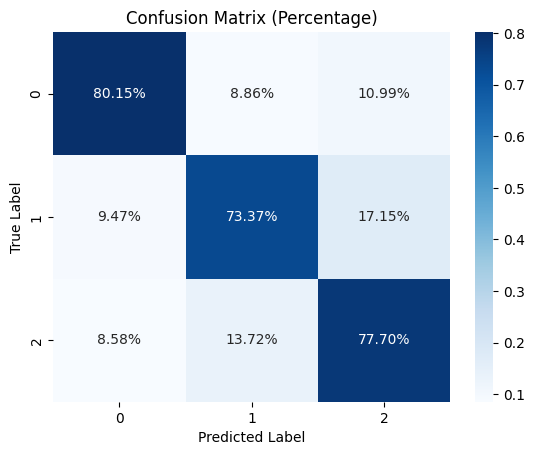

In [31]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

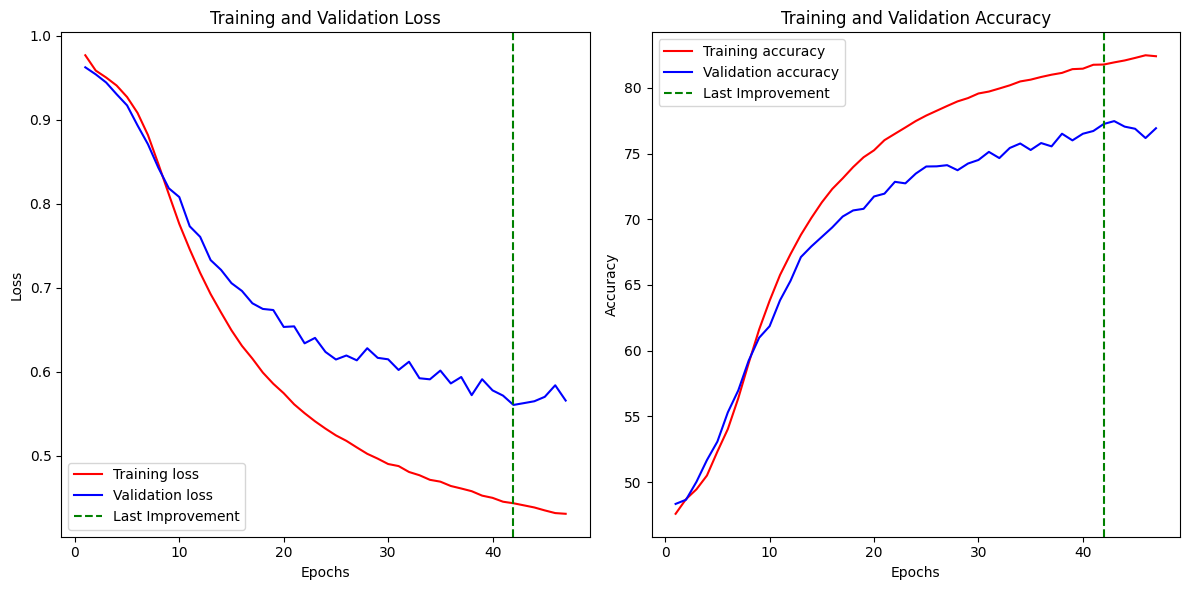

In [32]:
with open('Models/GRU_history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs
last_improvement_epoch = len(train_loss) - 5

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement') 
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

### 1D Convolutional NN

In [33]:
class ConvNet(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ConvNet, self).__init__()

        # Conv1D Layers
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(32)  
        self.gelu1 = nn.GELU()
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)
        self.dropout1 = nn.Dropout(0.2)  # Dropout
        
        

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm1d(64)  
        self.gelu2 = nn.GELU()
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)
        self.dropout2 = nn.Dropout(0.2)  # Dropout
        

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm1d(128)  
        self.gelu3 = nn.GELU()
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)
        self.dropout3 = nn.Dropout(0.2)  # Dropout
        

        # Flatten layer 
        self.seq_length_after_conv_and_pool = 20 // 2 // 2 // 2 # Pooling 3 times with stride 2

        # Define Linear layers with Batch Normalization, GELU, and Dropout
        self.linear1 = nn.Linear(128 * self.seq_length_after_conv_and_pool, 64)
        self.batch_norm_lin1 = nn.BatchNorm1d(64)
        self.gelu_lin1 = nn.GELU()
        self.dropout_lin1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, 32)
        self.batch_norm_lin2 = nn.BatchNorm1d(32)
        self.gelu_lin2 = nn.GELU()
        self.dropout_lin2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(32, 16)
        self.batch_norm_lin3 = nn.BatchNorm1d(16)
        self.gelu_lin3 = nn.GELU()

        # Output layer
        self.output_layer = nn.Linear(16, output_dim)


    def forward(self, x):
        # Assuming x shape is (batch_size, seq_length, num_features)
        # Conv1d expects (batch_size, in_channels, seq_length), so transpose x
        x = x.transpose(1, 2)  # Now x shape: (batch_size, num_features, seq_length)

        # Apply Conv1D layers followed by pooling
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.gelu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.gelu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.gelu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = x.view(-1, 128 * self.seq_length_after_conv_and_pool)

        # Pass through Linear layers
        x = self.linear1(x)
        x = self.batch_norm_lin1(x)
        x = self.gelu_lin1(x)
        x = self.dropout_lin1(x)

        x = self.linear2(x)
        x = self.batch_norm_lin2(x)
        x = self.gelu_lin2(x)
        x = self.dropout_lin2(x)

        x = self.linear3(x)
        x = self.batch_norm_lin3(x)
        x = self.gelu_lin3(x)

        # Output layer
        x = self.output_layer(x)
        
        return x 


In [34]:
# Parameters
num_features = 19  # Number of input features per time step
num_classes = 3  # Example number of output classes
output_dim = 3

# Initialize the model
model = ConvNet(num_features=num_features, num_classes=num_classes)

In [35]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: cpu


ConvNet(
  (conv1): Conv1d(19, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu1): GELU(approximate='none')
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu2): GELU(approximate='none')
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu3): GELU(approximate='none')
  (pool3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (dropout3): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=256, out_featur

In [36]:
# Loss Function
criterion = nn.CrossEntropyLoss()

In [37]:
optimizer = optim.Adam(model.parameters())

In [38]:
num_epochs = 10000000

# Early Stopping and Model Checkpoint can be manually implemented in the training loop
best_val_loss = float('inf')
patience = 10  # For early stopping

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)



In [ ]:
# initialize history
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}


print('start fitting')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # for history
        # Calculate predictions for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
         # Update progress bar
        current_loss = running_loss / (i + 1)
        current_accuracy = 100 * correct / total
        pbar_train.set_postfix({'loss' : current_loss, 'accuracy': current_accuracy})
        
    # Calculate average loss and accuracy over the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_eval = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    with torch.no_grad():
        for i, (inputs, labels) in pbar_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # for history
            # Calculate predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_val_loss = val_loss / (i + 1)
            current_val_accuracy = 100 * val_correct / val_total
            pbar_eval.set_postfix({'val_loss': current_val_loss, 'val_accuracy': current_val_accuracy})
            
    # Calculate average loss and accuracy over the validation set
    val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Append to history after each epoch
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    
    # for record in command prompt
    logs = f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n'
        
    print(logs)
    with open('logs.txt','a') as f:
        f.write(logs)

    
    
    # Early stopping and Model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Models/best_model_state_dict.pth')
        torch.save(model, 'Models/best_model.pth')
        patience = 5  # Reset patience since we found a better model
    else:
        patience -= 1
        if patience == 0:
            break
    
    # Garbage collection
    gc.collect()

    
print("Training complete")


with open('Models/Conv1D_history.json', 'w') as f:
    json.dump(history, f)
print('Saved history.json')

# Save final model
torch.save(model.state_dict(), 'Models/Conv1D_model_state_dict.pth')
torch.save(model, 'Models/Conv1D_model.pth')
print('Saved Conv1D model')


In [39]:
state_dict = torch.load('Models/Conv1D_model_state_dict.pth')
model.load_state_dict(state_dict)

# Setting device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = model.to(device)

In [40]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    # Wrap your loader with tqdm for a progress bar
    pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch 1/1")
    for i, (images, labels) in pbar_test:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update progress bar
        # pbar_test.set_postfix({'loss': running_loss / (i + 1)})

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')



Epoch 1/1: 100%|██████████| 460/460 [00:04<00:00, 104.55it/s]

Accuracy of the model on the test images: 48.962676787446604%


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.5023402570672139
Recall: 0.489626767874466
F1 Score: 0.47370574930500847
Confusion Matrix:
 [[10708  1422  6587]
 [ 3764  4778 11153]
 [ 3536  3526 13283]]


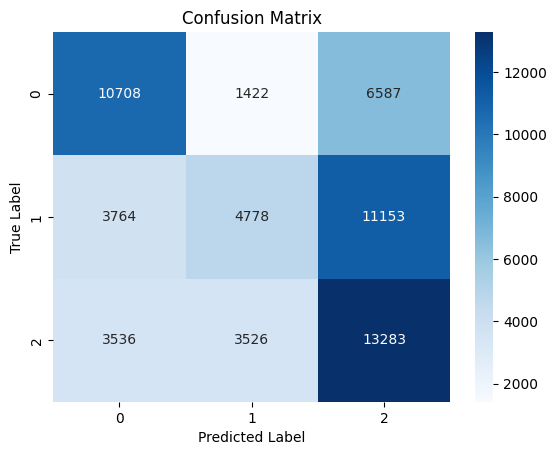

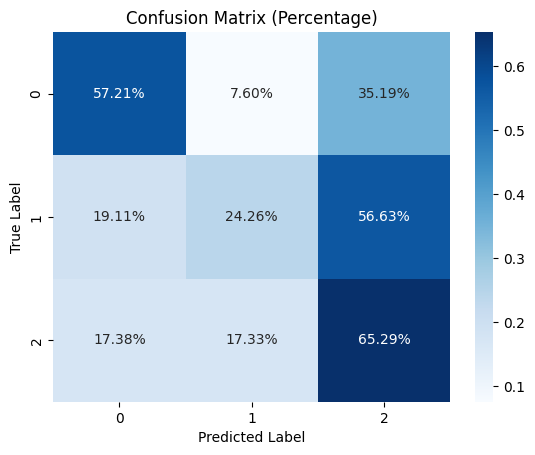

In [42]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

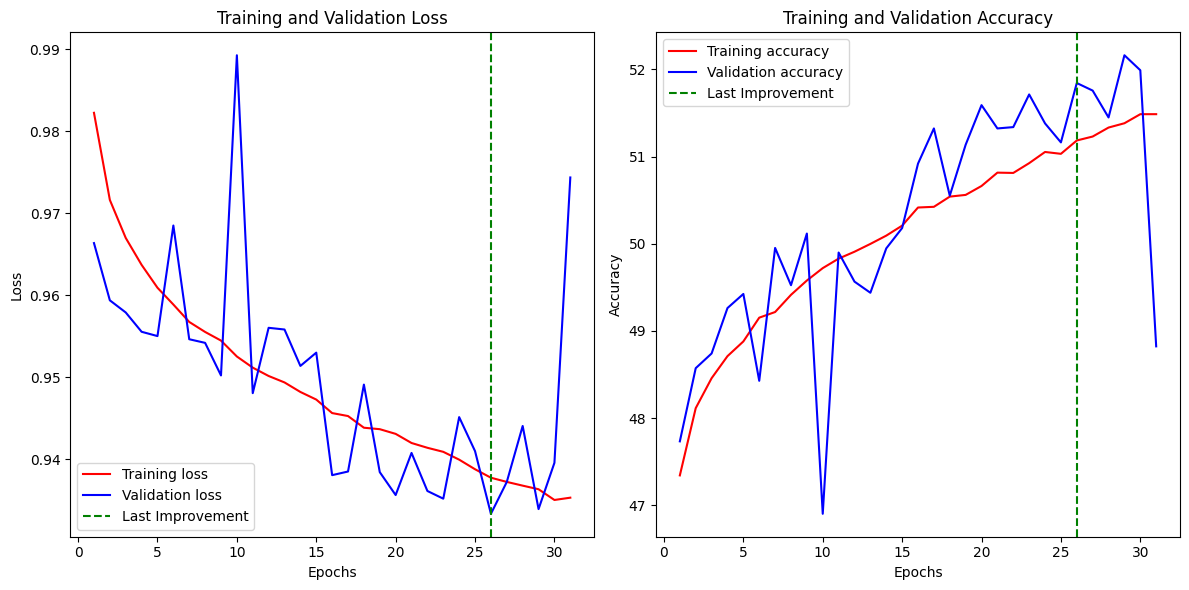

In [43]:
with open('Models/Conv1D_history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs
last_improvement_epoch = len(train_loss) - 5

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement') 
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

### Transformer Models

In [9]:
import math

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, seq_length, num_classes, d_model=64, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        # Input embedding layer
        self.embedding = nn.Linear(input_dim, d_model)

        # Positional Encoding (Not using nn.Embedding here to keep it simple)
        self.positional_encoding = PositionalEncoding(d_model, dropout, seq_length)

        # Transformer
        transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_encoder_layers)


        # Define Linear layers with Batch Normalization, GELU, and Dropout
        self.linear1 = nn.Linear(seq_length * d_model, 64)
        self.batch_norm_lin1 = nn.BatchNorm1d(64)
        self.gelu_lin1 = nn.GELU()
        self.dropout_lin1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, 32)
        self.batch_norm_lin2 = nn.BatchNorm1d(32)
        self.gelu_lin2 = nn.GELU()
        self.dropout_lin2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(32, 16)
        self.batch_norm_lin3 = nn.BatchNorm1d(16)
        self.gelu_lin3 = nn.GELU()

        # Output layer
        self.output_layer = nn.Linear(16, output_dim)


    def forward(self, src):
        # Assuming src shape is (batch_size, seq_length, input_dim)
        # Transformer expects (seq_length, batch_size, input_dim), so transpose src
        src = src.transpose(0, 1)

        # Embedding and positional encoding
        src = self.embedding(src)  # Now shape is (seq_length, batch_size, d_model)
        src = self.positional_encoding(src)

        # Transformer
        output = self.transformer(src)

        # For linear layers, we'll consider the output of all positions.
        # Reshape output to (batch_size, seq_length * d_model) before passing to linear layers.
        # Note: Adjusting this as per the expected input for linear layers.
        output = output.transpose(0, 1)  # Change back to (batch_size, seq_length, d_model)
        x = output.flatten(start_dim=1)

        # Pass through Linear layers
        x = self.linear1(x)
        x = self.batch_norm_lin1(x)
        x = self.gelu_lin1(x)
        x = self.dropout_lin1(x)

        x = self.linear2(x)
        x = self.batch_norm_lin2(x)
        x = self.gelu_lin2(x)
        x = self.dropout_lin2(x)

        x = self.linear3(x)
        x = self.batch_norm_lin3(x)
        x = self.gelu_lin3(x)

        # Output layer
        x = self.output_layer(x)
        
        return x 

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [11]:
# Example parameters
input_dim = 19  # Number of features per time step
seq_length = 20  # Sequence length
num_classes = 3  # Number of output classes

# Initialize the model
model = TransformerModel(input_dim=input_dim, output_dim=num_classes, seq_length=seq_length, num_classes=num_classes, d_model=64, nhead=4, num_encoder_layers=2, dim_feedforward=256, dropout=0.1)


/Users/bae/pytorch/torch/nn/modules/transformer.py:292: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: cpu


TransformerModel(
  (embedding): Linear(in_features=19, out_features=64, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (linear1): Linear(in_features=1280, out_features=64, bias=True)
  (batch_norm_lin1): BatchNorm1d(64, eps=1e-05, momen

In [13]:
# Loss Function
criterion = nn.CrossEntropyLoss()

In [14]:
optimizer = optim.Adam(model.parameters())

In [15]:
num_epochs = 10000000

# Early Stopping and Model Checkpoint can be manually implemented in the training loop
best_val_loss = float('inf')
patience = 10  # For early stopping

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)



In [ ]:
# initialize history
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}


print('start fitting')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # for history
        # Calculate predictions for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
         # Update progress bar
        current_loss = running_loss / (i + 1)
        current_accuracy = 100 * correct / total
        pbar_train.set_postfix({'loss' : current_loss, 'accuracy': current_accuracy})
        
    # Calculate average loss and accuracy over the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_eval = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    with torch.no_grad():
        for i, (inputs, labels) in pbar_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # for history
            # Calculate predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_val_loss = val_loss / (i + 1)
            current_val_accuracy = 100 * val_correct / val_total
            pbar_eval.set_postfix({'val_loss': current_val_loss, 'val_accuracy': current_val_accuracy})
            
    # Calculate average loss and accuracy over the validation set
    val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Append to history after each epoch
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    
    # for record in command prompt
    logs = f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n'
        
    print(logs)
    with open('logs.txt','a') as f:
        f.write(logs)

    
    
    # Early stopping and Model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Models/best_model_state_dict.pth')
        torch.save(model, 'Models/best_model.pth')
        patience = 5  # Reset patience since we found a better model
    else:
        patience -= 1
        if patience == 0:
            break
    
    # Garbage collection
    gc.collect()

    
print("Training complete")


with open('Models/Transformer_history.json', 'w') as f:
    json.dump(history, f)
print('Saved history.json')

# Save final model
torch.save(model.state_dict(), 'Models/Transformer_model_state_dict.pth')
torch.save(model, 'Models/Transformer_model.pth')
print('Saved Transformer model')


In [16]:
state_dict = torch.load('Models/Transformer_model_state_dict.pth')
model.load_state_dict(state_dict)

# Setting device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = model.to(device)

In [17]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    # Wrap your loader with tqdm for a progress bar
    pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch 1/1")
    for i, (images, labels) in pbar_test:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update progress bar
        # pbar_test.set_postfix({'loss': running_loss / (i + 1)})

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')



Epoch 1/1:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch 1/1: 100%|██████████| 460/460 [00:07<00:00, 60.78it/s]

Accuracy of the model on the test images: 60.137515530064505%


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.602657056754118
Recall: 0.601375155300645
F1 Score: 0.5959293471478223
Confusion Matrix:
 [[13445  2146  3126]
 [ 3262  8511  7922]
 [ 3222  3744 13379]]


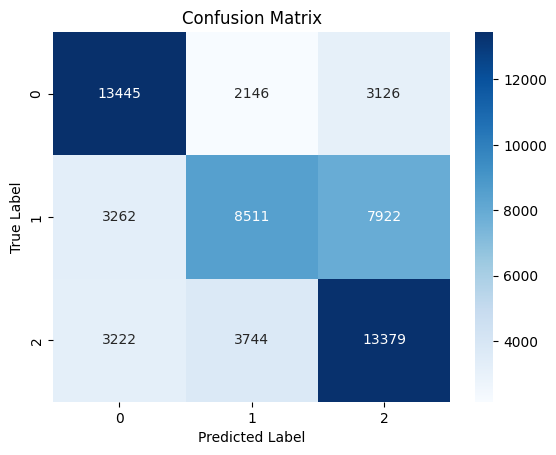

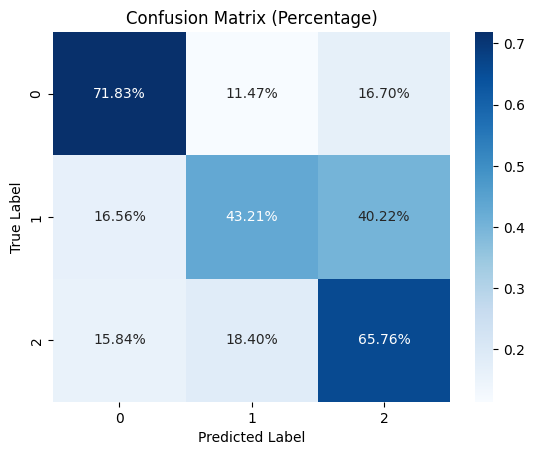

In [19]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

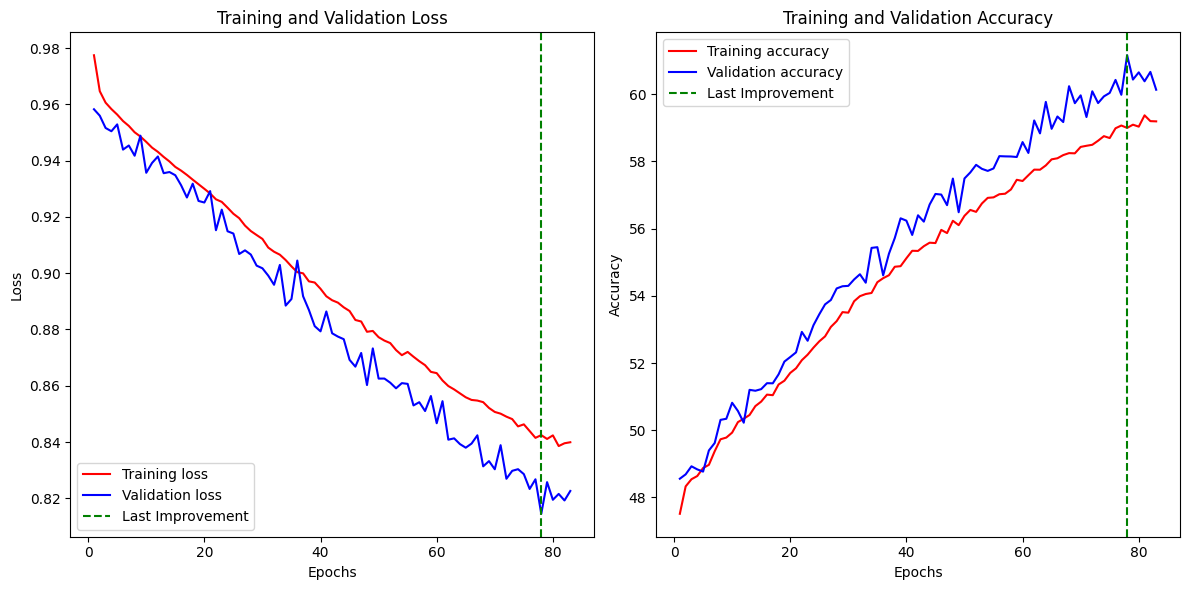

In [20]:
with open('Models/Transformer_history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs
last_improvement_epoch = len(train_loss) - 5

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement') 
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

### Linear Models

In [21]:
class LinearModel(nn.Module):
    def __init__(self, seq_length, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        
        # Calculate the flattened input size
        self.flattened_size = seq_length * input_dim
        
        # Define Linear layers with Batch Normalization, GELU, and Dropout
        self.linear1 = nn.Linear(self.flattened_size, 128)
        self.batch_norm_lin1 = nn.BatchNorm1d(128)
        self.gelu_lin1 = nn.GELU()
        self.dropout_lin1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(128, 48)
        self.batch_norm_lin2 = nn.BatchNorm1d(48)
        self.gelu_lin2 = nn.GELU()
        self.dropout_lin2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(48, 16)
        self.batch_norm_lin3 = nn.BatchNorm1d(16)
        self.gelu_lin3 = nn.GELU()

        # Output layer
        self.output_layer = nn.Linear(16, output_dim)


    def forward(self, x):
        # Flatten the input
        x = x.view(-1, self.flattened_size)  # Reshape input to (batch_size, seq_length*input_dim)
        
        # Pass through Linear layers
        x = self.linear1(x)
        x = self.batch_norm_lin1(x)
        x = self.gelu_lin1(x)
        x = self.dropout_lin1(x)

        x = self.linear2(x)
        x = self.batch_norm_lin2(x)
        x = self.gelu_lin2(x)
        x = self.dropout_lin2(x)

        x = self.linear3(x)
        x = self.batch_norm_lin3(x)
        x = self.gelu_lin3(x)

        # Output layer
        x = self.output_layer(x)
        
        return x


In [22]:
# Parameters for the model
seq_length = 20
input_dim = 19
output_dim = 3  # Example output dimension, adjust as needed

# Create the model instance
model = LinearModel(seq_length, input_dim, output_dim)



In [23]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: cpu


LinearModel(
  (linear1): Linear(in_features=380, out_features=128, bias=True)
  (batch_norm_lin1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu_lin1): GELU(approximate='none')
  (dropout_lin1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=128, out_features=48, bias=True)
  (batch_norm_lin2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu_lin2): GELU(approximate='none')
  (dropout_lin2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=48, out_features=16, bias=True)
  (batch_norm_lin3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu_lin3): GELU(approximate='none')
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)

In [24]:
# Loss Function
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

num_epochs = 10000000

# Early Stopping and Model Checkpoint can be manually implemented in the training loop
best_val_loss = float('inf')
patience = 10  # For early stopping

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)

In [ ]:
# initialize history
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}


print('start fitting')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # for history
        # Calculate predictions for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
         # Update progress bar
        current_loss = running_loss / (i + 1)
        current_accuracy = 100 * correct / total
        pbar_train.set_postfix({'loss' : current_loss, 'accuracy': current_accuracy})
        
    # Calculate average loss and accuracy over the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_eval = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    with torch.no_grad():
        for i, (inputs, labels) in pbar_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # for history
            # Calculate predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_val_loss = val_loss / (i + 1)
            current_val_accuracy = 100 * val_correct / val_total
            pbar_eval.set_postfix({'val_loss': current_val_loss, 'val_accuracy': current_val_accuracy})
            
    # Calculate average loss and accuracy over the validation set
    val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Append to history after each epoch
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    
    # for record in command prompt
    logs = f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n'
        
    print(logs)
    with open('logs.txt','a') as f:
        f.write(logs)

    
    
    # Early stopping and Model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Models/best_model_state_dict.pth')
        torch.save(model, 'Models/best_model.pth')
        patience = 5  # Reset patience since we found a better model
    else:
        patience -= 1
        if patience == 0:
            break
    
    # Garbage collection
    gc.collect()

    
print("Training complete")


with open('Models/Linear_history.json', 'w') as f:
    json.dump(history, f)
print('Saved history.json')

# Save final model
torch.save(model.state_dict(), 'Models/Linear_model_state_dict.pth')
torch.save(model, 'Models/Linear_model.pth')
print('Saved Linear model')


In [25]:
state_dict = torch.load('Models/Linear_model_state_dict.pth')
model.load_state_dict(state_dict)

# Setting device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = model.to(device)

In [26]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    # Wrap your loader with tqdm for a progress bar
    pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch 1/1")
    for i, (images, labels) in pbar_test:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update progress bar
        # pbar_test.set_postfix({'loss': running_loss / (i + 1)})

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')



Epoch 1/1: 100%|██████████| 460/460 [00:01<00:00, 273.57it/s]

Accuracy of the model on the test images: 49.92256241809486%


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.4966099219966697
Recall: 0.4992256241809487
F1 Score: 0.48513755824240834
Confusion Matrix:
 [[12847  1325  4545]
 [ 4732  5412  9551]
 [ 4726  4545 11074]]


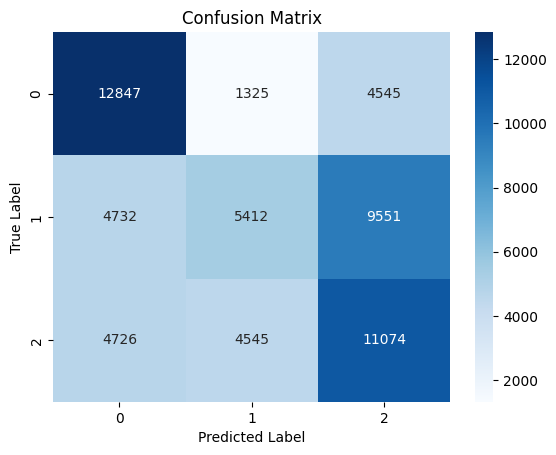

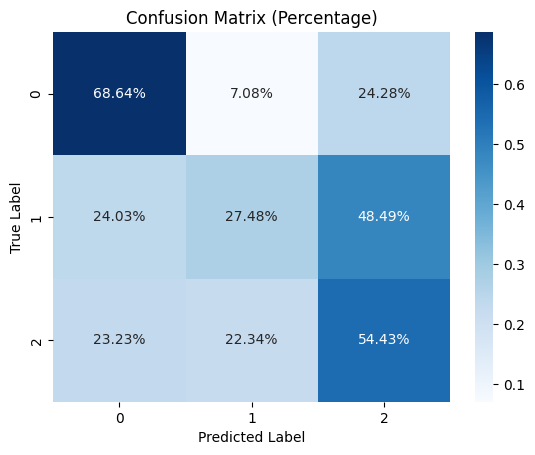

In [28]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

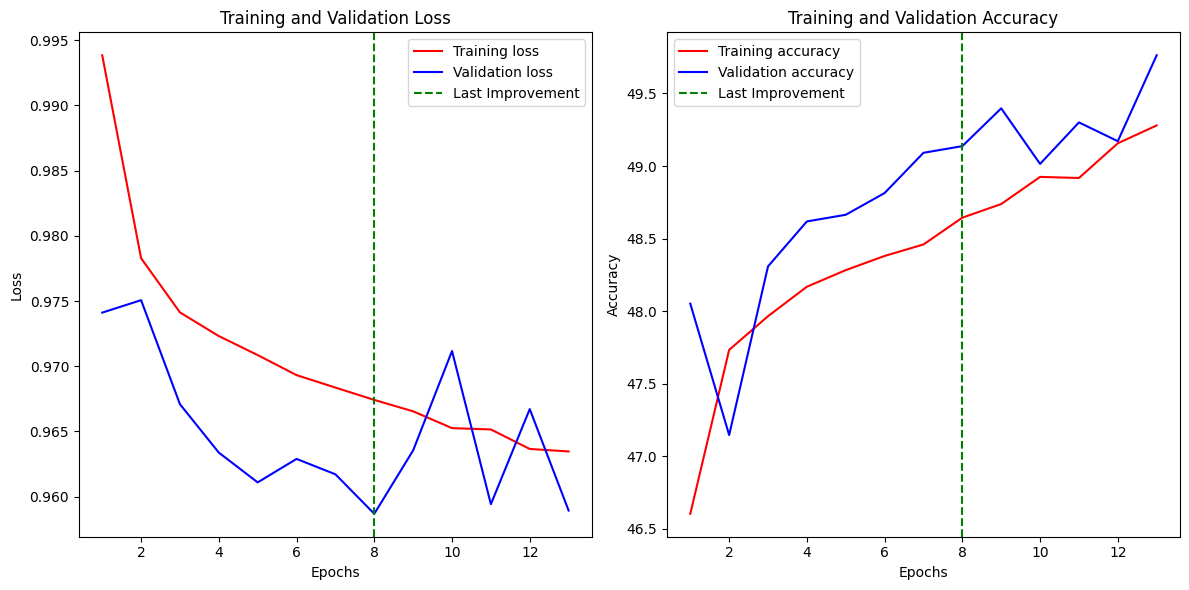

In [29]:
with open('Models/Linear_history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs
last_improvement_epoch = len(train_loss) - 5

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement') 
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from tqdm import  tqdm

import os, json, gc, io, joblib
from contextlib import redirect_stdout

from sklearn.model_selection import train_test_split

### import Data 40

In [ ]:
# Raw data
matrix_array_40 = np.load('Data/matrix_array_40_normalized.npy')
answer_array_40 = np.load('Data/answer_array_40.npy')

In [ ]:
matrix_array_40.shape, answer_array_40.shape, type(matrix_array_40[0][0][0])

((587343, 40, 19), (587343, 3), numpy.float64)

In [ ]:
labels = torch.tensor(answer_array_40)
indices = torch.argmax(labels, dim=1)
mapped_labels = torch.tensor([1 if i == 0 else 2 if i == 1 else 0 for i in indices])
mapped_labels

# answer = chunk.iloc[i+19][['plus_6', 'minus_6', 'zero_6']].tolist()
# 1 means up
# 2 means down
# 0 means None

tensor([1, 1, 1,  ..., 0, 0, 0])

In [ ]:
X = matrix_array_40
y = mapped_labels

X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.8, random_state=1, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

In [ ]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(117468, 40, 19) (234937, 40, 19) (234938, 40, 19)
torch.Size([117468]) torch.Size([234937]) torch.Size([234938])


In [ ]:
X_train.shape[1:], X_train[0].shape

((40, 19), (40, 19))

In [ ]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use torch.long for labels if using CrossEntropyLoss
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 128  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Now your DataLoaders are ready to be used in the training loop

/var/folders/mj/m28wyfp54xbfc1pkqh5_b64r0000gn/T/ipykernel_19032/4118101478.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use torch.long for labels if using CrossEntropyLoss
/var/folders/mj/m28wyfp54xbfc1pkqh5_b64r0000gn/T/ipykernel_19032/4118101478.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
/var/folders/mj/m28wyfp54xbfc1pkqh5_b64r0000gn/T/ipykernel_19032/4118101478.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

In [ ]:
X_train_tensor.shape

torch.Size([117468, 40, 19])

### LSTM1

In [ ]:
# Custom LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()

        # Multi-layer LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=3, batch_first=True, dropout=0.2)

        # Flatten layer 

        # Define Linear layers with Batch Normalization, GELU, and Dropout
        self.linear1 = nn.Linear(hidden_dim, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.gelu1 = nn.GELU()
        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, 32)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.gelu2 = nn.GELU()
        self.dropout2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(32, 16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.gelu3 = nn.GELU()

        # Output layer
        self.output_layer = nn.Linear(16, output_dim)

    def forward(self, x):
        # Pass input through LSTM layers
        # print("Output type1:", type(x))
        (lstm_out, _) = self.lstm(x)

        # Taking the output of the last time step
        # print("Output type2:", type(x))
        x = lstm_out[:, -1, :]

        # Pass through Linear layers
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.gelu1(x)
        x = self.dropout1(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.gelu2(x)
        x = self.dropout2(x)

        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.gelu3(x)

        # Output layer
        x = self.output_layer(x)
        
        return x 


In [ ]:
# Initialize the model
model = LSTMModel(input_dim=19, hidden_dim=128, output_dim=3)

In [ ]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: cpu


LSTMModel(
  (lstm): LSTM(19, 128, num_layers=3, batch_first=True, dropout=0.2)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu1): GELU(approximate='none')
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu2): GELU(approximate='none')
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (batch_norm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu3): GELU(approximate='none')
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)

In [ ]:
# Loss Function
criterion = nn.CrossEntropyLoss()

In [ ]:
decay_params = []  # Parameters for which to apply weight decay
no_decay_params = []  # Parameters for which not to apply weight decay

for name, param in model.named_parameters():
    if not param.requires_grad:
        continue  # Skip parameters that don't require gradients
    if len(param.shape) == 1 or name.endswith(".bias") or "norm" in name:
        no_decay_params.append(param)  # No decay for biases and BN parameters
    else:
        decay_params.append(param)

In [ ]:
# Now, set the optimizer with two parameter groups
optimizer = optim.Adam([
    {'params': no_decay_params, 'weight_decay': 0.0},  # No weight decay
    {'params': decay_params, 'weight_decay': 0.00}  # Apply weight decay
], lr=0.02)

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
num_epochs = 10000000

# Early Stopping and Model Checkpoint can be manually implemented in the training loop
best_val_loss = float('inf')
patience = 10  # For early stopping

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)



In [ ]:
# initialize history
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}


print('start fitting')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # for history
        # Calculate predictions for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
         # Update progress bar
        current_loss = running_loss / (i + 1)
        current_accuracy = 100 * correct / total
        pbar_train.set_postfix({'loss' : current_loss, 'accuracy': current_accuracy})
        
    # Calculate average loss and accuracy over the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_eval = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    with torch.no_grad():
        for i, (inputs, labels) in pbar_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # for history
            # Calculate predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_val_loss = val_loss / (i + 1)
            current_val_accuracy = 100 * val_correct / val_total
            pbar_eval.set_postfix({'val_loss': current_val_loss, 'val_accuracy': current_val_accuracy})
            
    # Calculate average loss and accuracy over the validation set
    val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Append to history after each epoch
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    
    # for record in command prompt
    logs = f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n'
        
    print(logs)
    with open('logs.txt','a') as f:
        f.write(logs)

    
    
    # Early stopping and Model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_state_dict.pth')
        torch.save(model, 'best_model.pth')
        patience = 5  # Reset patience since we found a better model
    else:
        patience -= 1
        if patience == 0:
            break
    
    # Garbage collection
    gc.collect()

    
print("Training complete")


with open('Models/LSTM_history.json', 'w') as f:
    json.dump(history, f)
print('Saved history.json')

# Save final model
torch.save(model.state_dict(), 'Models/LSTM_model_state_dict.pth')
torch.save(model, 'Models/LSTM_model.pth')
print('Saved LSTM model')


In [ ]:
state_dict = torch.load('Models/LSTM_model_state_dict.pth')
model.load_state_dict(state_dict)

# Setting device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = model.to(device)

In [ ]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    # Wrap your loader with tqdm for a progress bar
    pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch 1/1")
    for i, (images, labels) in pbar_test:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update progress bar
        # pbar_test.set_postfix({'loss': running_loss / (i + 1)})

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')



Epoch 1/1:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch 1/1: 100%|██████████| 460/460 [00:14<00:00, 31.06it/s]

Accuracy of the model on the test images: 84.61800296134929%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.8463517659871065
Recall: 0.8461800296134928
F1 Score: 0.8461344106910423
Confusion Matrix:
 [[16189  1206  1322]
 [ 1288 16158  2249]
 [ 1257  1716 17372]]


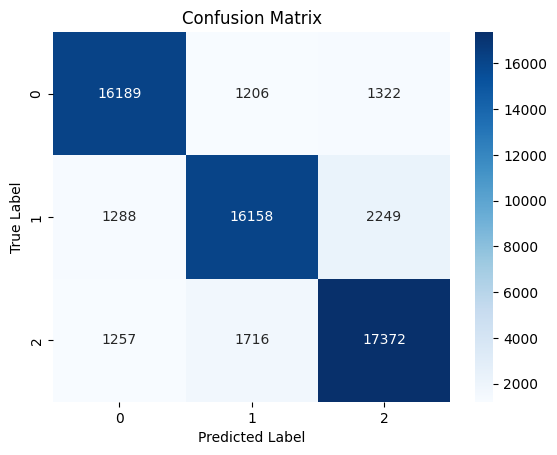

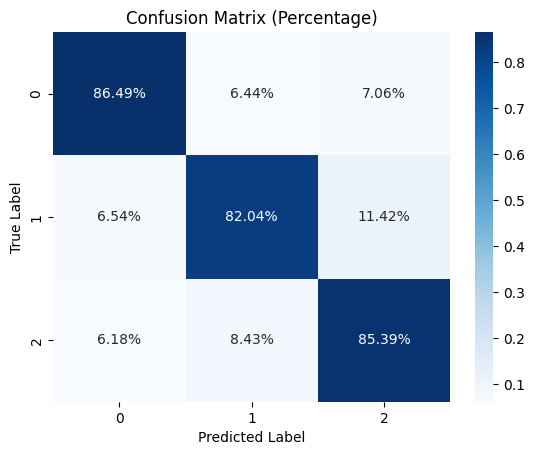

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

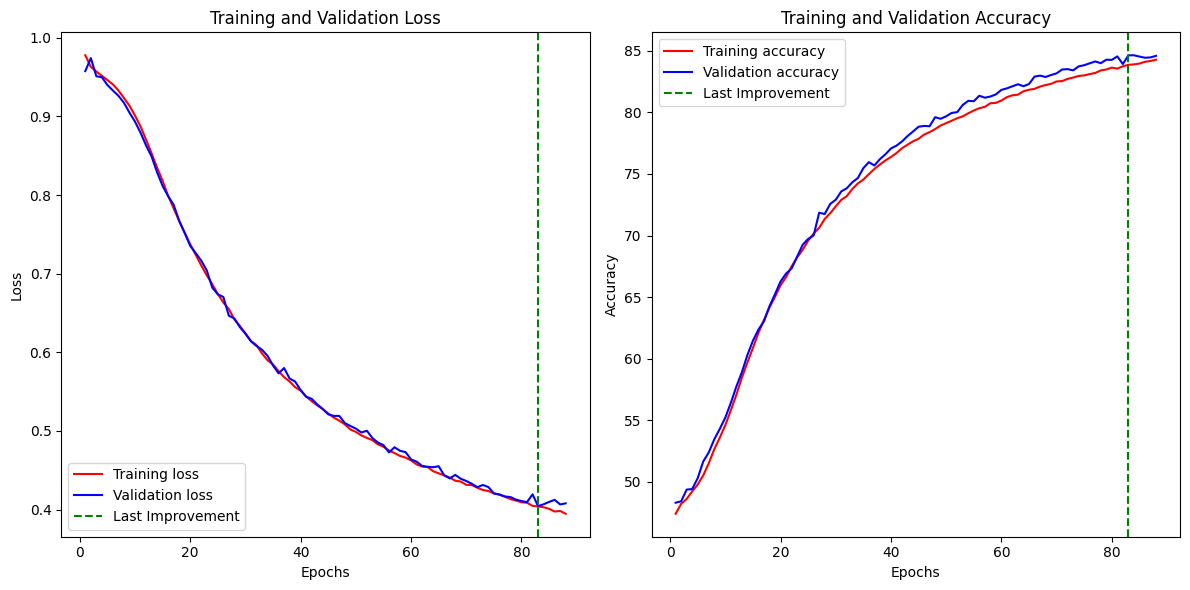

In [ ]:
with open('Models/LSTM_history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs
last_improvement_epoch = len(train_loss) - 5

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement') 
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

### GRUs (Gated Recurrent Units)

In [ ]:
# Custom GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # GRU Layer
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)

        # Flatten layer 

        # Define Linear layers with Batch Normalization, GELU, and Dropout
        self.linear1 = nn.Linear(hidden_dim, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.gelu1 = nn.GELU()
        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, 32)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.gelu2 = nn.GELU()
        self.dropout2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(32, 16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.gelu3 = nn.GELU()

        # Output layer
        self.output_layer = nn.Linear(16, output_dim)

    def forward(self, x):
        # Pass input through GRU layers
        # print("Output type1:", type(x))
        gru_out, _ = self.gru(x)

        # Taking the output of the last time step
        # print("Output type2:", type(x))
        x = gru_out[:, -1, :]

        # Pass through Linear layers
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = self.gelu1(x)
        x = self.dropout1(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.gelu2(x)
        x = self.dropout2(x)

        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.gelu3(x)

        # Output layer
        x = self.output_layer(x)
        
        return x 


In [ ]:
input_dim = 19  # Number of input features
hidden_dim = 128  # Number of hidden units
output_dim = 3  # Number of output classes
num_layers = 2  # Number of GRU layers

# initialize Model
model = GRUModel(input_dim, hidden_dim, output_dim, num_layers)

In [ ]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)


Using device: cpu


GRUModel(
  (gru): GRU(19, 128, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu1): GELU(approximate='none')
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu2): GELU(approximate='none')
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (batch_norm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu3): GELU(approximate='none')
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)

In [ ]:
# Loss Function
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
num_epochs = 10000000

# Early Stopping and Model Checkpoint can be manually implemented in the training loop
best_val_loss = float('inf')
patience = 10  # For early stopping

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)



In [ ]:
# initialize history
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}


print('start fitting')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # for history
        # Calculate predictions for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
         # Update progress bar
        current_loss = running_loss / (i + 1)
        current_accuracy = 100 * correct / total
        pbar_train.set_postfix({'loss' : current_loss, 'accuracy': current_accuracy})
        
    # Calculate average loss and accuracy over the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_eval = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    with torch.no_grad():
        for i, (inputs, labels) in pbar_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # for history
            # Calculate predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_val_loss = val_loss / (i + 1)
            current_val_accuracy = 100 * val_correct / val_total
            pbar_eval.set_postfix({'val_loss': current_val_loss, 'val_accuracy': current_val_accuracy})
            
    # Calculate average loss and accuracy over the validation set
    val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Append to history after each epoch
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    
    # for record in command prompt
    logs = f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n'
        
    print(logs)
    with open('logs.txt','a') as f:
        f.write(logs)

    
    
    # Early stopping and Model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Models/best_model_state_dict.pth')
        torch.save(model, 'Models/best_model.pth')
        patience = 5  # Reset patience since we found a better model
    else:
        patience -= 1
        if patience == 0:
            break
    
    # Garbage collection
    gc.collect()

    
print("Training complete")


with open('Models/GRU_history.json', 'w') as f:
    json.dump(history, f)
print('Saved history.json')

# Save final model
torch.save(model.state_dict(), 'Models/GRU_model_state_dict.pth')
torch.save(model, 'Models/GRU_model.pth')
print('Saved GRU model')


In [ ]:
state_dict = torch.load('Models/GRU_model_state_dict.pth')
model.load_state_dict(state_dict)

# Setting device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = model.to(device)

In [ ]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    # Wrap your loader with tqdm for a progress bar
    pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch 1/1")
    for i, (images, labels) in pbar_test:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update progress bar
        # pbar_test.set_postfix({'loss': running_loss / (i + 1)})

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')



Epoch 1/1:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch 1/1: 100%|██████████| 460/460 [00:16<00:00, 28.27it/s]

Accuracy of the model on the test images: 77.02911993464609%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.7706763988395465
Recall: 0.7702911993464608
F1 Score: 0.7702527511042238
Confusion Matrix:
 [[15001  1659  2057]
 [ 1866 14451  3378]
 [ 1746  2791 15808]]


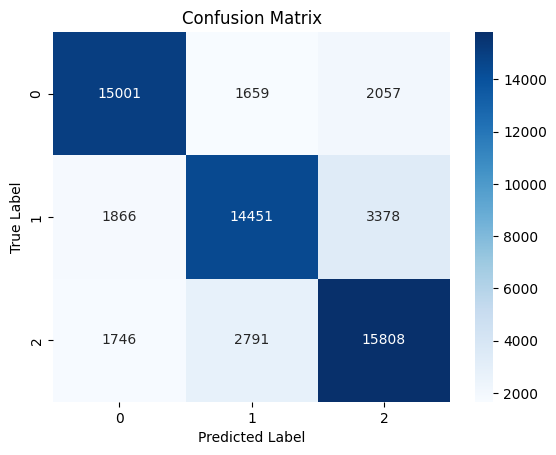

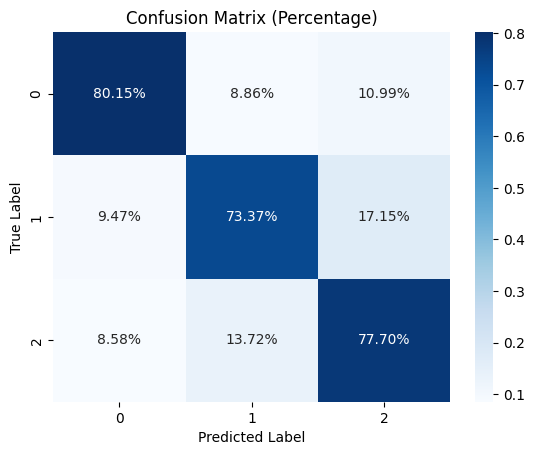

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

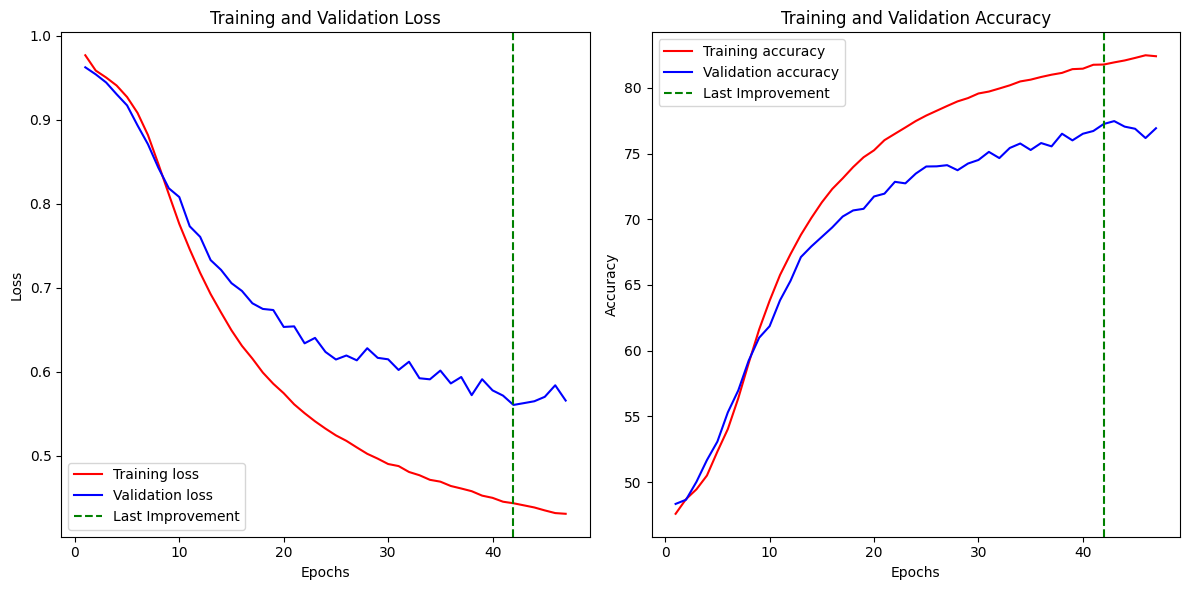

In [ ]:
with open('Models/GRU_history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs
last_improvement_epoch = len(train_loss) - 5

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement') 
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

### 1D Convolutional NN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ConvNet, self).__init__()

        # Conv1D Layers
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(32)  
        self.gelu1 = nn.GELU()
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)
        self.dropout1 = nn.Dropout(0.2)  # Dropout
        
        

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm1d(64)  
        self.gelu2 = nn.GELU()
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)
        self.dropout2 = nn.Dropout(0.2)  # Dropout
        

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm1d(128)  
        self.gelu3 = nn.GELU()
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2, padding=0)
        self.dropout3 = nn.Dropout(0.2)  # Dropout
        

        # Flatten layer 
        self.seq_length_after_conv_and_pool = 20 // 2 // 2 // 2 # Pooling 3 times with stride 2

        # Define Linear layers with Batch Normalization, GELU, and Dropout
        self.linear1 = nn.Linear(128 * self.seq_length_after_conv_and_pool, 64)
        self.batch_norm_lin1 = nn.BatchNorm1d(64)
        self.gelu_lin1 = nn.GELU()
        self.dropout_lin1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, 32)
        self.batch_norm_lin2 = nn.BatchNorm1d(32)
        self.gelu_lin2 = nn.GELU()
        self.dropout_lin2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(32, 16)
        self.batch_norm_lin3 = nn.BatchNorm1d(16)
        self.gelu_lin3 = nn.GELU()

        # Output layer
        self.output_layer = nn.Linear(16, output_dim)


    def forward(self, x):
        # Assuming x shape is (batch_size, seq_length, num_features)
        # Conv1d expects (batch_size, in_channels, seq_length), so transpose x
        x = x.transpose(1, 2)  # Now x shape: (batch_size, num_features, seq_length)

        # Apply Conv1D layers followed by pooling
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.gelu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.gelu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.gelu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = x.view(-1, 128 * self.seq_length_after_conv_and_pool)

        # Pass through Linear layers
        x = self.linear1(x)
        x = self.batch_norm_lin1(x)
        x = self.gelu_lin1(x)
        x = self.dropout_lin1(x)

        x = self.linear2(x)
        x = self.batch_norm_lin2(x)
        x = self.gelu_lin2(x)
        x = self.dropout_lin2(x)

        x = self.linear3(x)
        x = self.batch_norm_lin3(x)
        x = self.gelu_lin3(x)

        # Output layer
        x = self.output_layer(x)
        
        return x 


In [ ]:
# Parameters
num_features = 19  # Number of input features per time step
num_classes = 3  # Example number of output classes
output_dim = 3

# Initialize the model
model = ConvNet(num_features=num_features, num_classes=num_classes)

In [ ]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: cpu


ConvNet(
  (conv1): Conv1d(19, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu1): GELU(approximate='none')
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu2): GELU(approximate='none')
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu3): GELU(approximate='none')
  (pool3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (dropout3): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=256, out_featur

In [ ]:
# Loss Function
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
num_epochs = 10000000

# Early Stopping and Model Checkpoint can be manually implemented in the training loop
best_val_loss = float('inf')
patience = 10  # For early stopping

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)



In [ ]:
# initialize history
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}


print('start fitting')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # for history
        # Calculate predictions for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
         # Update progress bar
        current_loss = running_loss / (i + 1)
        current_accuracy = 100 * correct / total
        pbar_train.set_postfix({'loss' : current_loss, 'accuracy': current_accuracy})
        
    # Calculate average loss and accuracy over the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_eval = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    with torch.no_grad():
        for i, (inputs, labels) in pbar_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # for history
            # Calculate predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_val_loss = val_loss / (i + 1)
            current_val_accuracy = 100 * val_correct / val_total
            pbar_eval.set_postfix({'val_loss': current_val_loss, 'val_accuracy': current_val_accuracy})
            
    # Calculate average loss and accuracy over the validation set
    val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Append to history after each epoch
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    
    # for record in command prompt
    logs = f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n'
        
    print(logs)
    with open('logs.txt','a') as f:
        f.write(logs)

    
    
    # Early stopping and Model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Models/best_model_state_dict.pth')
        torch.save(model, 'Models/best_model.pth')
        patience = 5  # Reset patience since we found a better model
    else:
        patience -= 1
        if patience == 0:
            break
    
    # Garbage collection
    gc.collect()

    
print("Training complete")


with open('Models/Conv1D_history.json', 'w') as f:
    json.dump(history, f)
print('Saved history.json')

# Save final model
torch.save(model.state_dict(), 'Models/Conv1D_model_state_dict.pth')
torch.save(model, 'Models/Conv1D_model.pth')
print('Saved Conv1D model')


In [ ]:
state_dict = torch.load('Models/Conv1D_model_state_dict.pth')
model.load_state_dict(state_dict)

# Setting device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = model.to(device)

In [ ]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    # Wrap your loader with tqdm for a progress bar
    pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch 1/1")
    for i, (images, labels) in pbar_test:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update progress bar
        # pbar_test.set_postfix({'loss': running_loss / (i + 1)})

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')



Epoch 1/1: 100%|██████████| 460/460 [00:04<00:00, 104.55it/s]

Accuracy of the model on the test images: 48.962676787446604%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.5023402570672139
Recall: 0.489626767874466
F1 Score: 0.47370574930500847
Confusion Matrix:
 [[10708  1422  6587]
 [ 3764  4778 11153]
 [ 3536  3526 13283]]


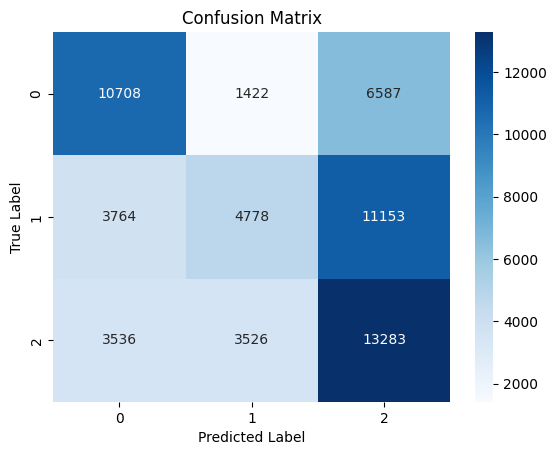

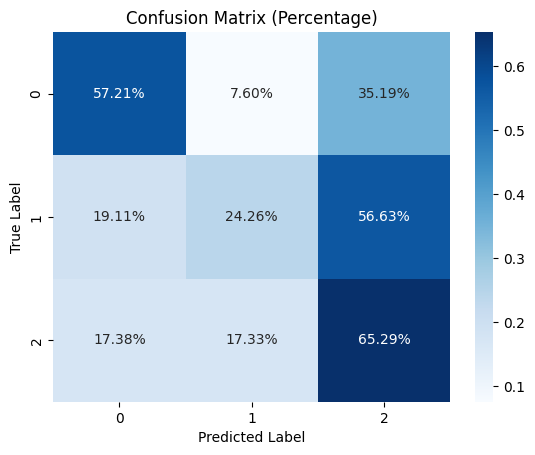

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

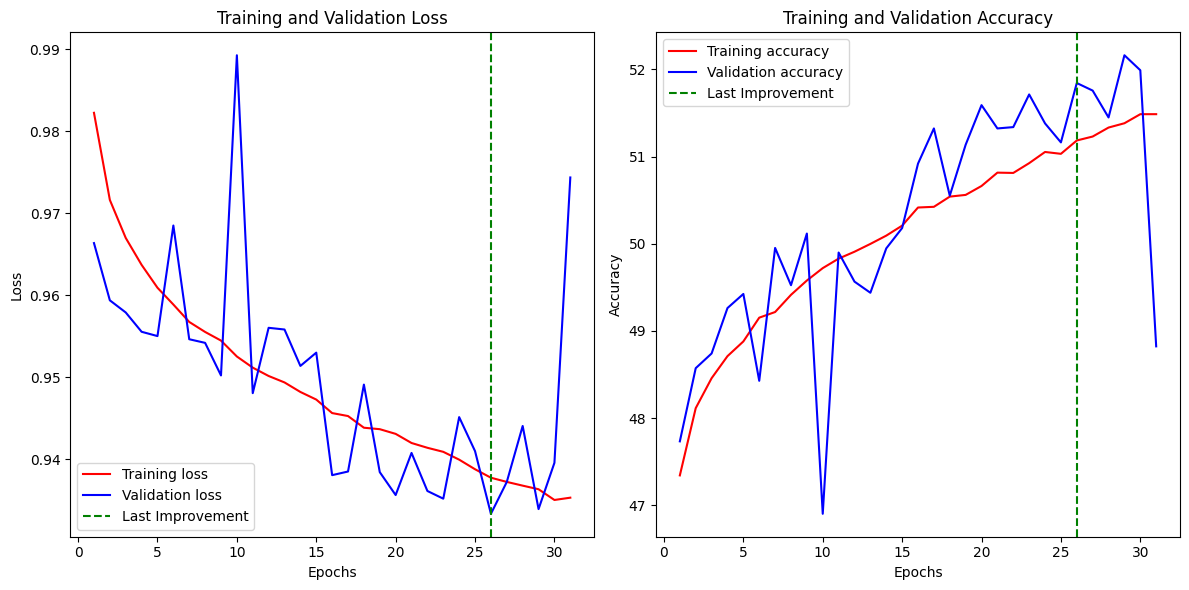

In [ ]:
with open('Models/Conv1D_history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs
last_improvement_epoch = len(train_loss) - 5

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement') 
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

### Transformer Models

In [ ]:
import math

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, seq_length, num_classes, d_model=64, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        # Input embedding layer
        self.embedding = nn.Linear(input_dim, d_model)

        # Positional Encoding (Not using nn.Embedding here to keep it simple)
        self.positional_encoding = PositionalEncoding(d_model, dropout, seq_length)

        # Transformer
        transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_encoder_layers)


        # Define Linear layers with Batch Normalization, GELU, and Dropout
        self.linear1 = nn.Linear(seq_length * d_model, 64)
        self.batch_norm_lin1 = nn.BatchNorm1d(64)
        self.gelu_lin1 = nn.GELU()
        self.dropout_lin1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, 32)
        self.batch_norm_lin2 = nn.BatchNorm1d(32)
        self.gelu_lin2 = nn.GELU()
        self.dropout_lin2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(32, 16)
        self.batch_norm_lin3 = nn.BatchNorm1d(16)
        self.gelu_lin3 = nn.GELU()

        # Output layer
        self.output_layer = nn.Linear(16, output_dim)


    def forward(self, src):
        # Assuming src shape is (batch_size, seq_length, input_dim)
        # Transformer expects (seq_length, batch_size, input_dim), so transpose src
        src = src.transpose(0, 1)

        # Embedding and positional encoding
        src = self.embedding(src)  # Now shape is (seq_length, batch_size, d_model)
        src = self.positional_encoding(src)

        # Transformer
        output = self.transformer(src)

        # For linear layers, we'll consider the output of all positions.
        # Reshape output to (batch_size, seq_length * d_model) before passing to linear layers.
        # Note: Adjusting this as per the expected input for linear layers.
        output = output.transpose(0, 1)  # Change back to (batch_size, seq_length, d_model)
        x = output.flatten(start_dim=1)

        # Pass through Linear layers
        x = self.linear1(x)
        x = self.batch_norm_lin1(x)
        x = self.gelu_lin1(x)
        x = self.dropout_lin1(x)

        x = self.linear2(x)
        x = self.batch_norm_lin2(x)
        x = self.gelu_lin2(x)
        x = self.dropout_lin2(x)

        x = self.linear3(x)
        x = self.batch_norm_lin3(x)
        x = self.gelu_lin3(x)

        # Output layer
        x = self.output_layer(x)
        
        return x 

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [ ]:
# Example parameters
input_dim = 19  # Number of features per time step
seq_length = 20  # Sequence length
num_classes = 3  # Number of output classes

# Initialize the model
model = TransformerModel(input_dim=input_dim, output_dim=num_classes, seq_length=seq_length, num_classes=num_classes, d_model=64, nhead=4, num_encoder_layers=2, dim_feedforward=256, dropout=0.1)


/Users/bae/pytorch/torch/nn/modules/transformer.py:292: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: cpu


TransformerModel(
  (embedding): Linear(in_features=19, out_features=64, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (linear1): Linear(in_features=1280, out_features=64, bias=True)
  (batch_norm_lin1): BatchNorm1d(64, eps=1e-05, momen

In [ ]:
# Loss Function
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
num_epochs = 10000000

# Early Stopping and Model Checkpoint can be manually implemented in the training loop
best_val_loss = float('inf')
patience = 10  # For early stopping

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)



In [ ]:
# initialize history
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}


print('start fitting')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # for history
        # Calculate predictions for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
         # Update progress bar
        current_loss = running_loss / (i + 1)
        current_accuracy = 100 * correct / total
        pbar_train.set_postfix({'loss' : current_loss, 'accuracy': current_accuracy})
        
    # Calculate average loss and accuracy over the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_eval = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    with torch.no_grad():
        for i, (inputs, labels) in pbar_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # for history
            # Calculate predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_val_loss = val_loss / (i + 1)
            current_val_accuracy = 100 * val_correct / val_total
            pbar_eval.set_postfix({'val_loss': current_val_loss, 'val_accuracy': current_val_accuracy})
            
    # Calculate average loss and accuracy over the validation set
    val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Append to history after each epoch
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    
    # for record in command prompt
    logs = f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n'
        
    print(logs)
    with open('logs.txt','a') as f:
        f.write(logs)

    
    
    # Early stopping and Model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Models/best_model_state_dict.pth')
        torch.save(model, 'Models/best_model.pth')
        patience = 5  # Reset patience since we found a better model
    else:
        patience -= 1
        if patience == 0:
            break
    
    # Garbage collection
    gc.collect()

    
print("Training complete")


with open('Models/Transformer_history.json', 'w') as f:
    json.dump(history, f)
print('Saved history.json')

# Save final model
torch.save(model.state_dict(), 'Models/Transformer_model_state_dict.pth')
torch.save(model, 'Models/Transformer_model.pth')
print('Saved Transformer model')


In [ ]:
state_dict = torch.load('Models/Transformer_model_state_dict.pth')
model.load_state_dict(state_dict)

# Setting device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = model.to(device)

In [ ]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    # Wrap your loader with tqdm for a progress bar
    pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch 1/1")
    for i, (images, labels) in pbar_test:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update progress bar
        # pbar_test.set_postfix({'loss': running_loss / (i + 1)})

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')



Epoch 1/1:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch 1/1: 100%|██████████| 460/460 [00:07<00:00, 60.78it/s]

Accuracy of the model on the test images: 60.137515530064505%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.602657056754118
Recall: 0.601375155300645
F1 Score: 0.5959293471478223
Confusion Matrix:
 [[13445  2146  3126]
 [ 3262  8511  7922]
 [ 3222  3744 13379]]


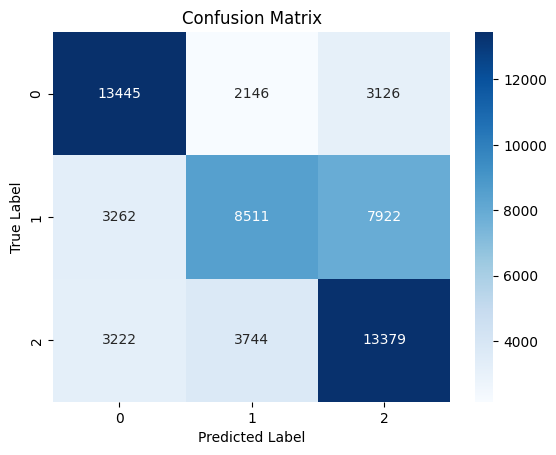

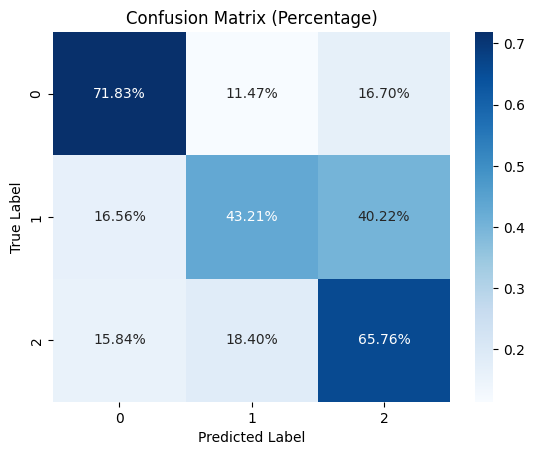

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

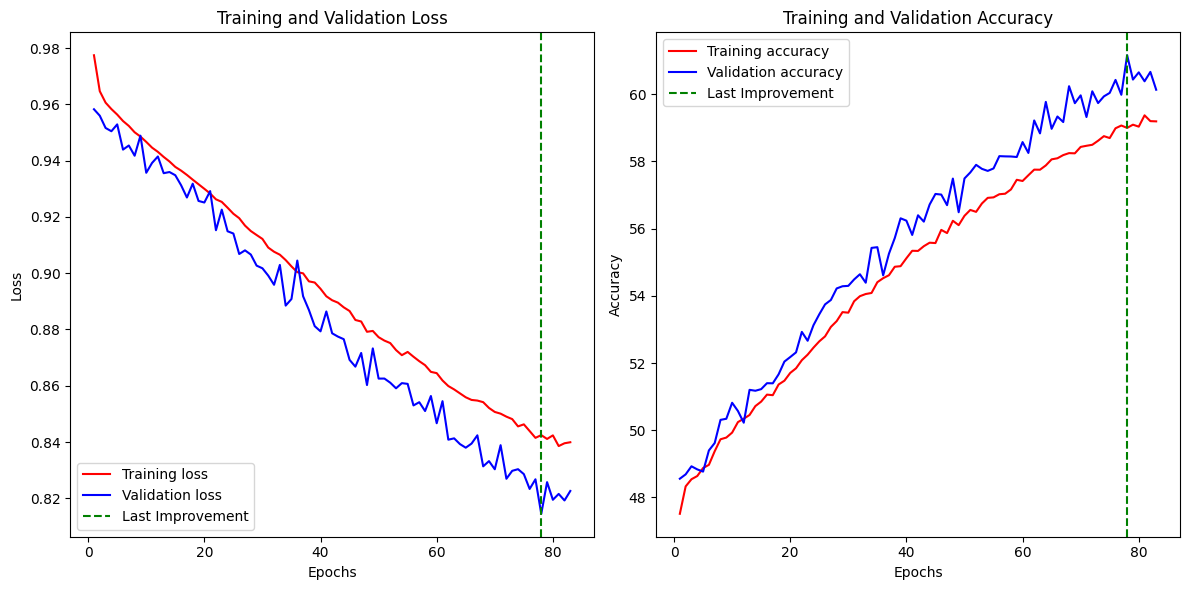

In [ ]:
with open('Models/Transformer_history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs
last_improvement_epoch = len(train_loss) - 5

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement') 
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

### Linear Models

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, seq_length, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        
        # Calculate the flattened input size
        self.flattened_size = seq_length * input_dim
        
        # Define Linear layers with Batch Normalization, GELU, and Dropout
        self.linear1 = nn.Linear(self.flattened_size, 128)
        self.batch_norm_lin1 = nn.BatchNorm1d(128)
        self.gelu_lin1 = nn.GELU()
        self.dropout_lin1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(128, 48)
        self.batch_norm_lin2 = nn.BatchNorm1d(48)
        self.gelu_lin2 = nn.GELU()
        self.dropout_lin2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(48, 16)
        self.batch_norm_lin3 = nn.BatchNorm1d(16)
        self.gelu_lin3 = nn.GELU()

        # Output layer
        self.output_layer = nn.Linear(16, output_dim)


    def forward(self, x):
        # Flatten the input
        x = x.view(-1, self.flattened_size)  # Reshape input to (batch_size, seq_length*input_dim)
        
        # Pass through Linear layers
        x = self.linear1(x)
        x = self.batch_norm_lin1(x)
        x = self.gelu_lin1(x)
        x = self.dropout_lin1(x)

        x = self.linear2(x)
        x = self.batch_norm_lin2(x)
        x = self.gelu_lin2(x)
        x = self.dropout_lin2(x)

        x = self.linear3(x)
        x = self.batch_norm_lin3(x)
        x = self.gelu_lin3(x)

        # Output layer
        x = self.output_layer(x)
        
        return x


In [ ]:
# Parameters for the model
seq_length = 20
input_dim = 19
output_dim = 3  # Example output dimension, adjust as needed

# Create the model instance
model = LinearModel(seq_length, input_dim, output_dim)



In [ ]:
# Setting device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: cpu


LinearModel(
  (linear1): Linear(in_features=380, out_features=128, bias=True)
  (batch_norm_lin1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu_lin1): GELU(approximate='none')
  (dropout_lin1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=128, out_features=48, bias=True)
  (batch_norm_lin2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu_lin2): GELU(approximate='none')
  (dropout_lin2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=48, out_features=16, bias=True)
  (batch_norm_lin3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu_lin3): GELU(approximate='none')
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)

In [ ]:
# Loss Function
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

num_epochs = 10000000

# Early Stopping and Model Checkpoint can be manually implemented in the training loop
best_val_loss = float('inf')
patience = 10  # For early stopping

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)

In [ ]:
# initialize history
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}


print('start fitting')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # for history
        # Calculate predictions for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
         # Update progress bar
        current_loss = running_loss / (i + 1)
        current_accuracy = 100 * correct / total
        pbar_train.set_postfix({'loss' : current_loss, 'accuracy': current_accuracy})
        
    # Calculate average loss and accuracy over the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Wrap your loader with tqdm for a progress bar
    pbar_eval = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    with torch.no_grad():
        for i, (inputs, labels) in pbar_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # for history
            # Calculate predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_val_loss = val_loss / (i + 1)
            current_val_accuracy = 100 * val_correct / val_total
            pbar_eval.set_postfix({'val_loss': current_val_loss, 'val_accuracy': current_val_accuracy})
            
    # Calculate average loss and accuracy over the validation set
    val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Append to history after each epoch
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    
    # for record in command prompt
    logs = f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n'
        
    print(logs)
    with open('logs.txt','a') as f:
        f.write(logs)

    
    
    # Early stopping and Model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Models/best_model_state_dict.pth')
        torch.save(model, 'Models/best_model.pth')
        patience = 5  # Reset patience since we found a better model
    else:
        patience -= 1
        if patience == 0:
            break
    
    # Garbage collection
    gc.collect()

    
print("Training complete")


with open('Models/Linear_history.json', 'w') as f:
    json.dump(history, f)
print('Saved history.json')

# Save final model
torch.save(model.state_dict(), 'Models/Linear_model_state_dict.pth')
torch.save(model, 'Models/Linear_model.pth')
print('Saved Linear model')


In [ ]:
state_dict = torch.load('Models/Linear_model_state_dict.pth')
model.load_state_dict(state_dict)

# Setting device to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = model.to(device)

In [ ]:
model.eval()  # Set the model to evaluation mode

# Initialize necessary metrics
correct = 0
total = 0

y_pred = []
y_true = []

# No need to track gradients for validation, which saves memory and computations
with torch.no_grad():
    # Wrap your loader with tqdm for a progress bar
    pbar_test = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch 1/1")
    for i, (images, labels) in pbar_test:
        # Move tensors to the same device as model
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move back to cpu and convert to numpy
        y_true.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update progress bar
        # pbar_test.set_postfix({'loss': running_loss / (i + 1)})

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')



Epoch 1/1: 100%|██████████| 460/460 [00:01<00:00, 273.57it/s]

Accuracy of the model on the test images: 49.92256241809486%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Calculating Precision, Recall, F1 Score, and Confusion Matrix
precision = precision_score(y_true, y_pred, average='weighted')  # or other averaging method
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Printing the metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.4966099219966697
Recall: 0.4992256241809487
F1 Score: 0.48513755824240834
Confusion Matrix:
 [[12847  1325  4545]
 [ 4732  5412  9551]
 [ 4726  4545 11074]]


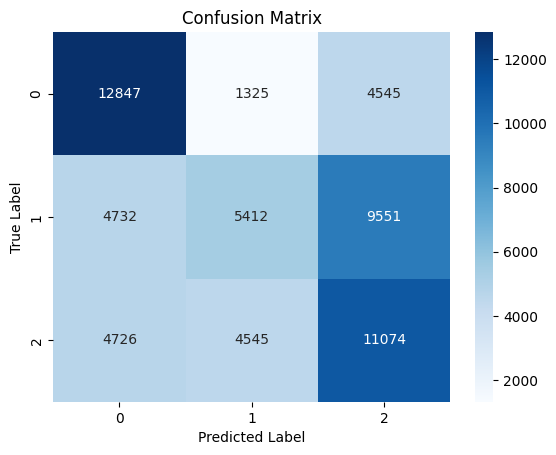

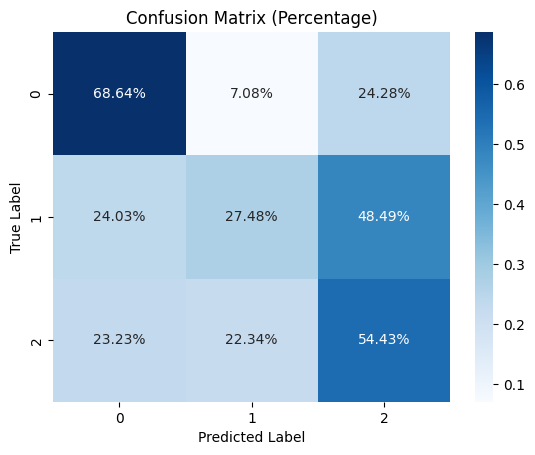

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

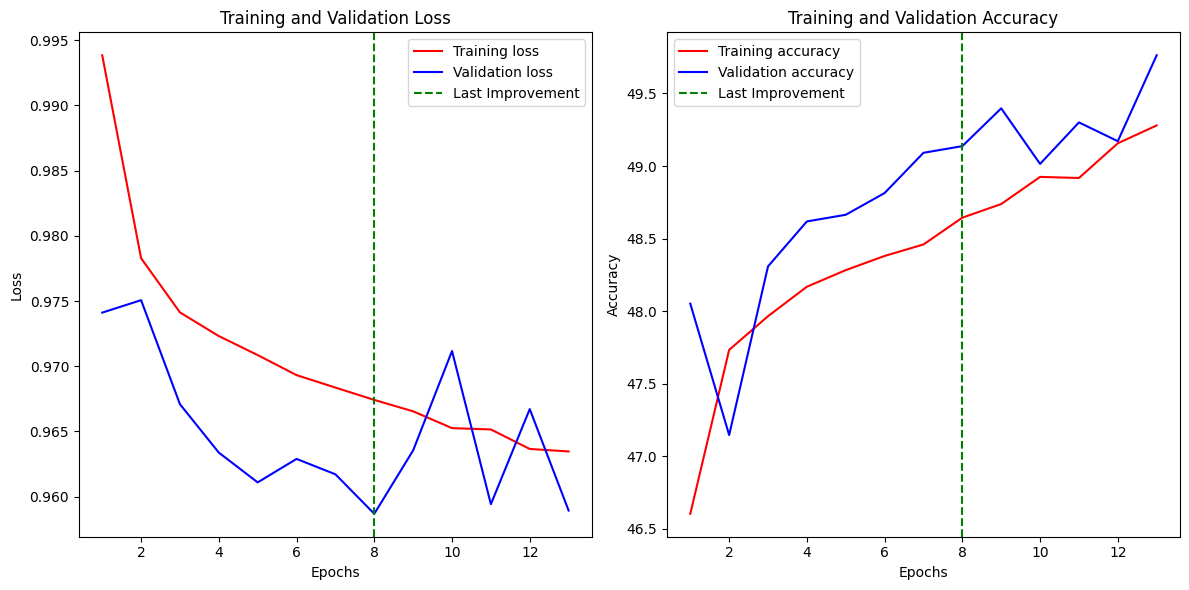

In [ ]:
with open('Models/Linear_history.json', 'r') as f:
    history = json.load(f)

# Extracting values for plotting
train_loss = history['train_loss']
val_loss = history['val_loss']
train_accuracy = history['train_accuracy']
val_accuracy = history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # 1, 2, ... , num_epochs
last_improvement_epoch = len(train_loss) - 5

# Creating subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting training and validation loss
ax[0].plot(epochs, train_loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement') 
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation accuracy
ax[1].plot(epochs, train_accuracy, 'r', label='Training accuracy')
ax[1].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[1].axvline(x=last_improvement_epoch, color='g', linestyle='--', label='Last Improvement')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from tqdm import  tqdm

import os, json, gc, io, joblib
from contextlib import redirect_stdout

from sklearn.model_selection import train_test_split

### import Data 40

In [ ]:
# Raw data
matrix_array_40 = np.load('Data/matrix_array_40_normalized.npy')
answer_array_40 = np.load('Data/answer_array_40.npy')